In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os

# Directory to save all results
SAVE_DIR = "figures"
os.makedirs(SAVE_DIR, exist_ok=True)

# Set a pastel color palette
pastel_palette = sns.color_palette("pastel")
ucsd_palette = sns.color_palette(
    [
        "#FFCD00",
        "#00629B",
        "#182B49",
        "#C69214",
        "#00C6D7",
        "#D462AD",
        "#F5F0E6",
        "#F3E500",
        "#FC8900",
        "#6E963B",
    ]
)
ucsd_accent_palette = sns.color_palette(["#00C6D7", "#D462AD", "#FC8900"])
sns.set_palette(ucsd_palette)

# Hardware specs tables


In [46]:
df = pd.read_csv("verilog/merged_data.csv")
df = df.rename(columns={df.columns[0]: "name"})
df.head()

,name,area,power,max_arrival_time
0,adder_combinational_bf16,1032.880,0.001745,2.50
1,adder_combinational_fast_bf16,927.542,0.001954,1.46
2,adder_combinational_fast_fp32,2886.370,0.010806,2.16
3,adder_combinational_fast_fp8,510.188,0.001988,1.20
4,adder_combinational_fp32,3230.040,0.005949,3.62


In [ ]:
# Extract dtype from name
def extract_dtype(name):
    match = re.search(r"_([^_]+)$", name)
    if match:
        return match.group(1)
    return None


# Add dtype column
df["dtype"] = df["name"].apply(extract_dtype)

# Create a custom order for dtypes
dtype_order = ["fp8", "bf16", "fp32"]
df["dtype_order"] = pd.Categorical(df["dtype"], categories=dtype_order, ordered=True)


# Extract architecture type (combinational, pipelined, stage_X)
def extract_architecture(name):
    if "combinational" in name:
        return "combinational"
    elif "pipelined" in name:
        return "pipelined"
    elif "stage" in name:
        match = re.search(r"stage_(\d+)", name)
        if match:
            return f"stage_{match.group(1)}"
    return "other"


# Fix the multiplier names to correctly identify them as pipelined
mask = df["name"].str.startswith("multiplier") & ~df["name"].str.contains(
    "stage|combinational"
)
df.loc[mask, "name"] = df.loc[mask, "name"].str.replace(
    "multiplier", "multiplier_pipelined"
)

# Re-extract the architecture information based on the updated names
df["architecture"] = df["name"].apply(extract_architecture)

# Display the updated names to verify
print("Updated multiplier names:")
print(df[df["name"].str.contains("multiplier_pipelined")]["name"].unique())


# Extract operation type (adder, multiplier, lmul)
def extract_operation(name):
    if name.startswith("adder"):
        return "adder"
    elif name.startswith("multiplier"):
        return "multiplier"
    elif name.startswith("lmul"):
        return "lmul"
    return "other"


df["operation"] = df["name"].apply(extract_operation)

# Extract if it's a fast implementation
df["is_fast"] = df["name"].apply(lambda x: "fast" in x)

# Display the first few rows to verify our transformations
display(df.head())

# Basic statistics by dtype
print("\nStatistics by Data Type:")
dtype_stats = df.groupby("dtype")[["area", "power", "max_arrival_time"]].mean()
dtype_stats = dtype_stats.reindex(dtype_order)
display(dtype_stats)

# Basic statistics by architecture
print("\nStatistics by Architecture:")
arch_stats = df.groupby("architecture")[["area", "power", "max_arrival_time"]].mean()
display(arch_stats)

# Basic statistics by operation
print("\nStatistics by Operation:")
op_stats = df.groupby("operation")[["area", "power", "max_arrival_time"]].mean()
display(op_stats)

Updated multiplier names:
['multiplier_pipelined_bf16' 'multiplier_pipelined_fast_bf16'
 'multiplier_pipelined_fast_fp32' 'multiplier_pipelined_fast_fp8'
 'multiplier_pipelined_fp32' 'multiplier_pipelined_fp8']


,name,area,power,max_arrival_time,dtype,dtype_order,architecture,operation,is_fast
0,adder_combinational_bf16,1032.880,0.001745,2.50,bf16,bf16,combinational,adder,False
1,adder_combinational_fast_bf16,927.542,0.001954,1.46,bf16,bf16,combinational,adder,True
2,adder_combinational_fast_fp32,2886.370,0.010806,2.16,fp32,fp32,combinational,adder,True
3,adder_combinational_fast_fp8,510.188,0.001988,1.20,fp8,fp8,combinational,adder,True
4,adder_combinational_fp32,3230.040,0.005949,3.62,fp32,fp32,combinational,adder,False



Statistics by Data Type:


,area,power,max_arrival_time
dtype,,,
fp8,286.892083,0.000546,0.665000
bf16,642.345583,0.001389,0.904583
fp32,2509.709833,0.017686,1.312083



Statistics by Architecture:


,area,power,max_arrival_time
architecture,,,
combinational,1486.718333,0.019565,1.568889
pipelined,1898.959000,0.002634,0.894444
stage_2,936.408833,0.005437,0.740000
stage_3,223.440000,0.000076,0.351111
stage_4,587.482833,0.000391,0.840000
stage_5,431.629333,0.000232,0.900000



Statistics by Operation:


,area,power,max_arrival_time
operation,,,
adder,981.371333,0.001621,1.007667
lmul,617.075167,0.000639,0.554167
multiplier,1522.956600,0.013820,1.076000


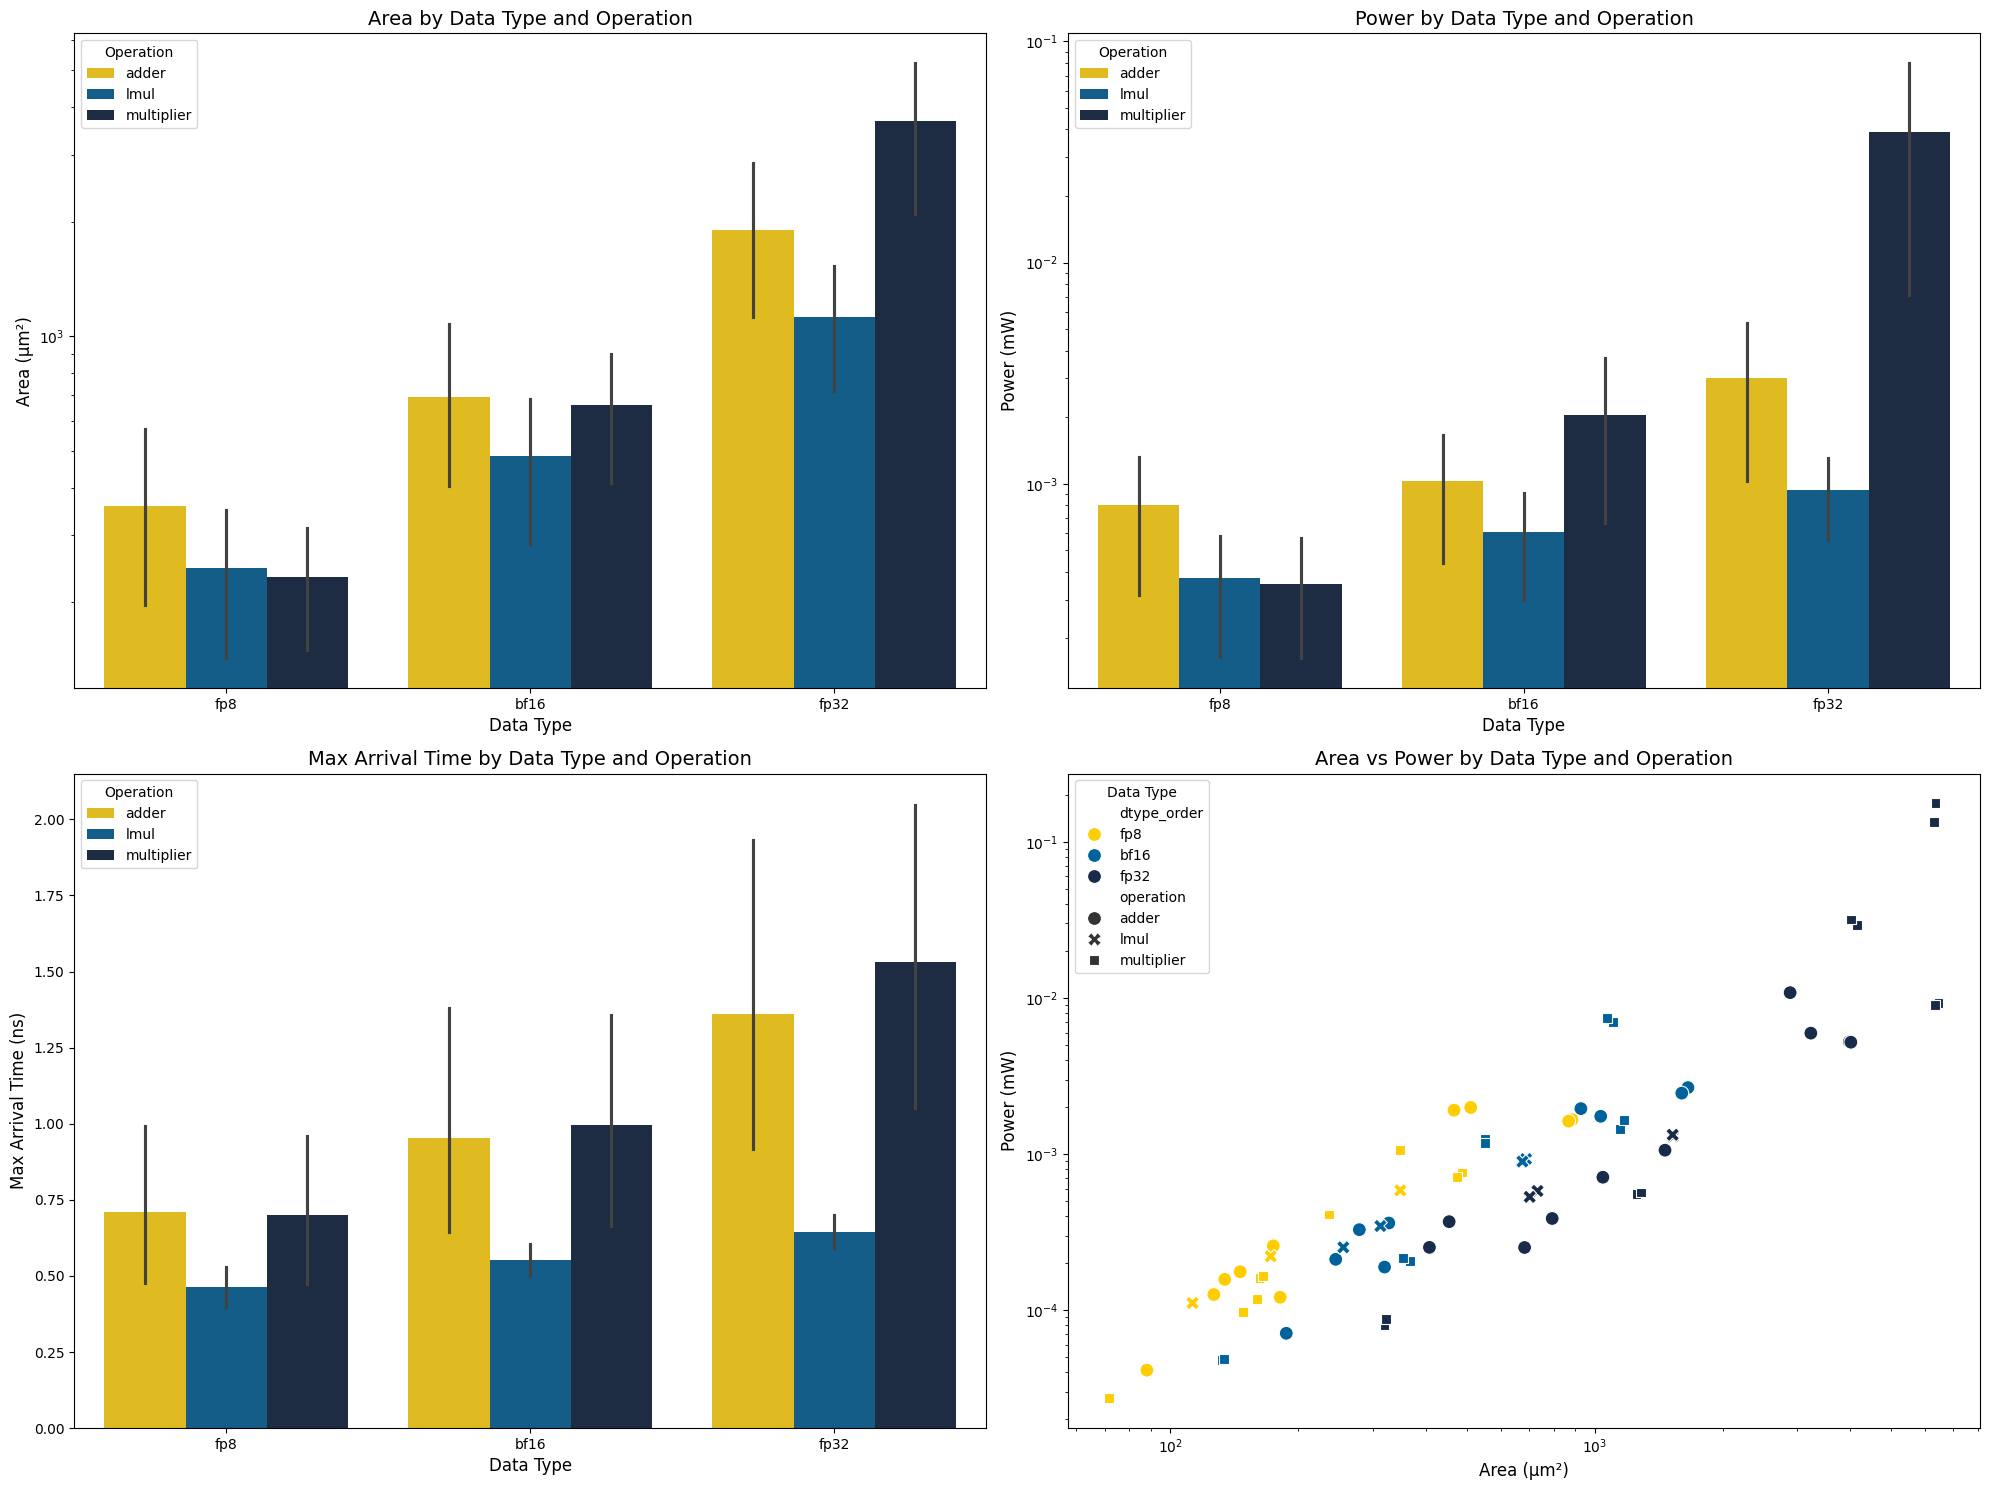

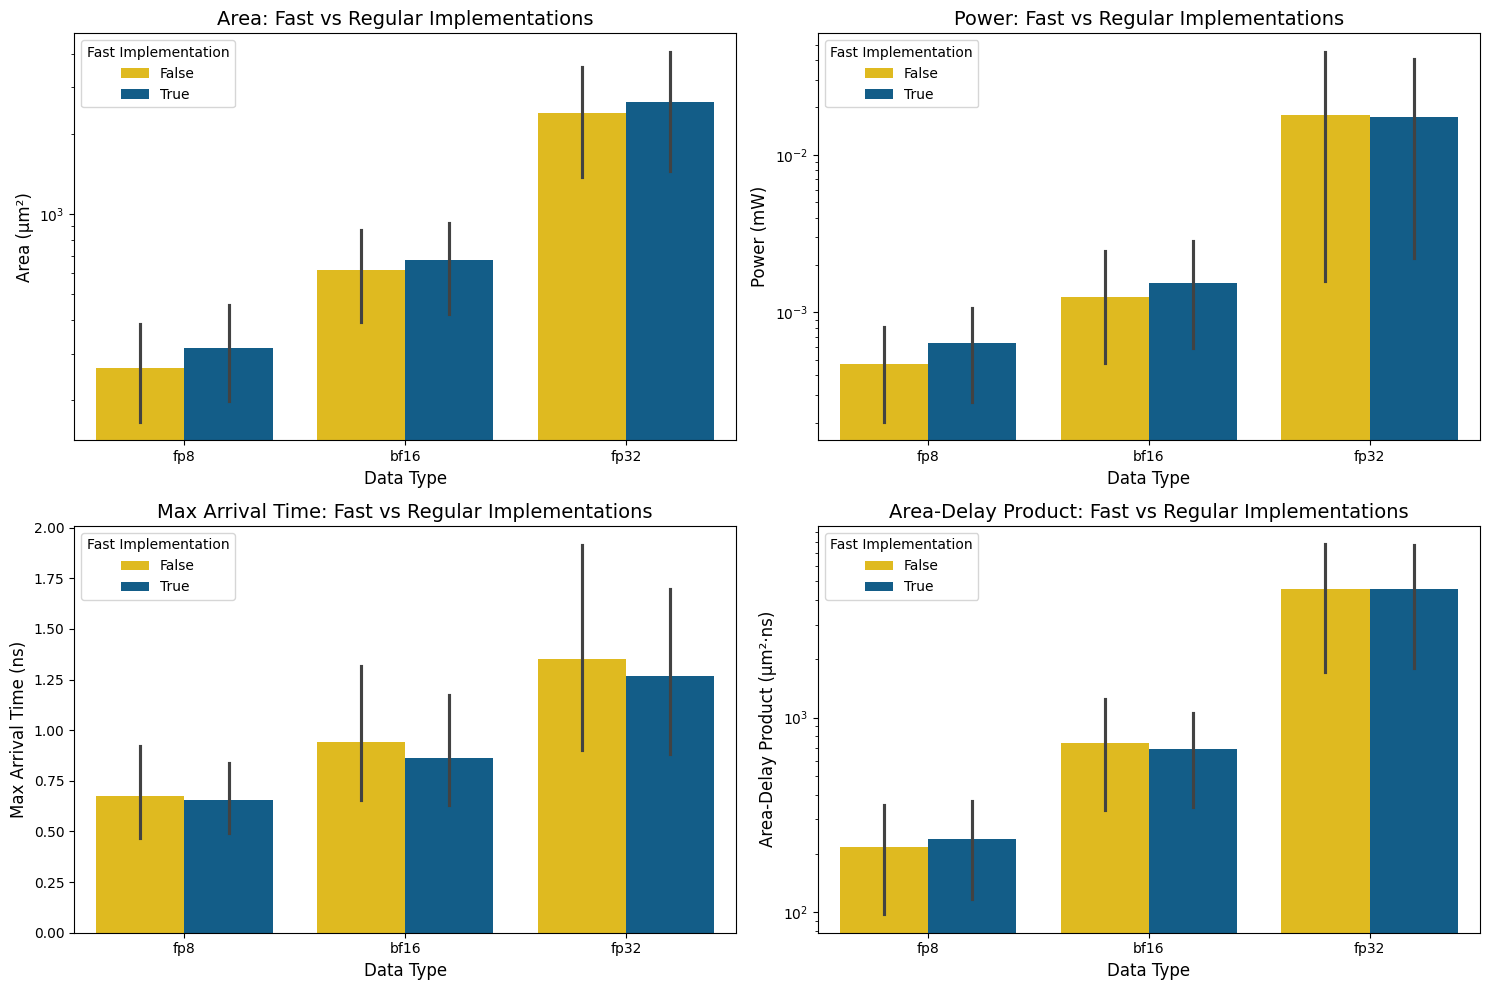

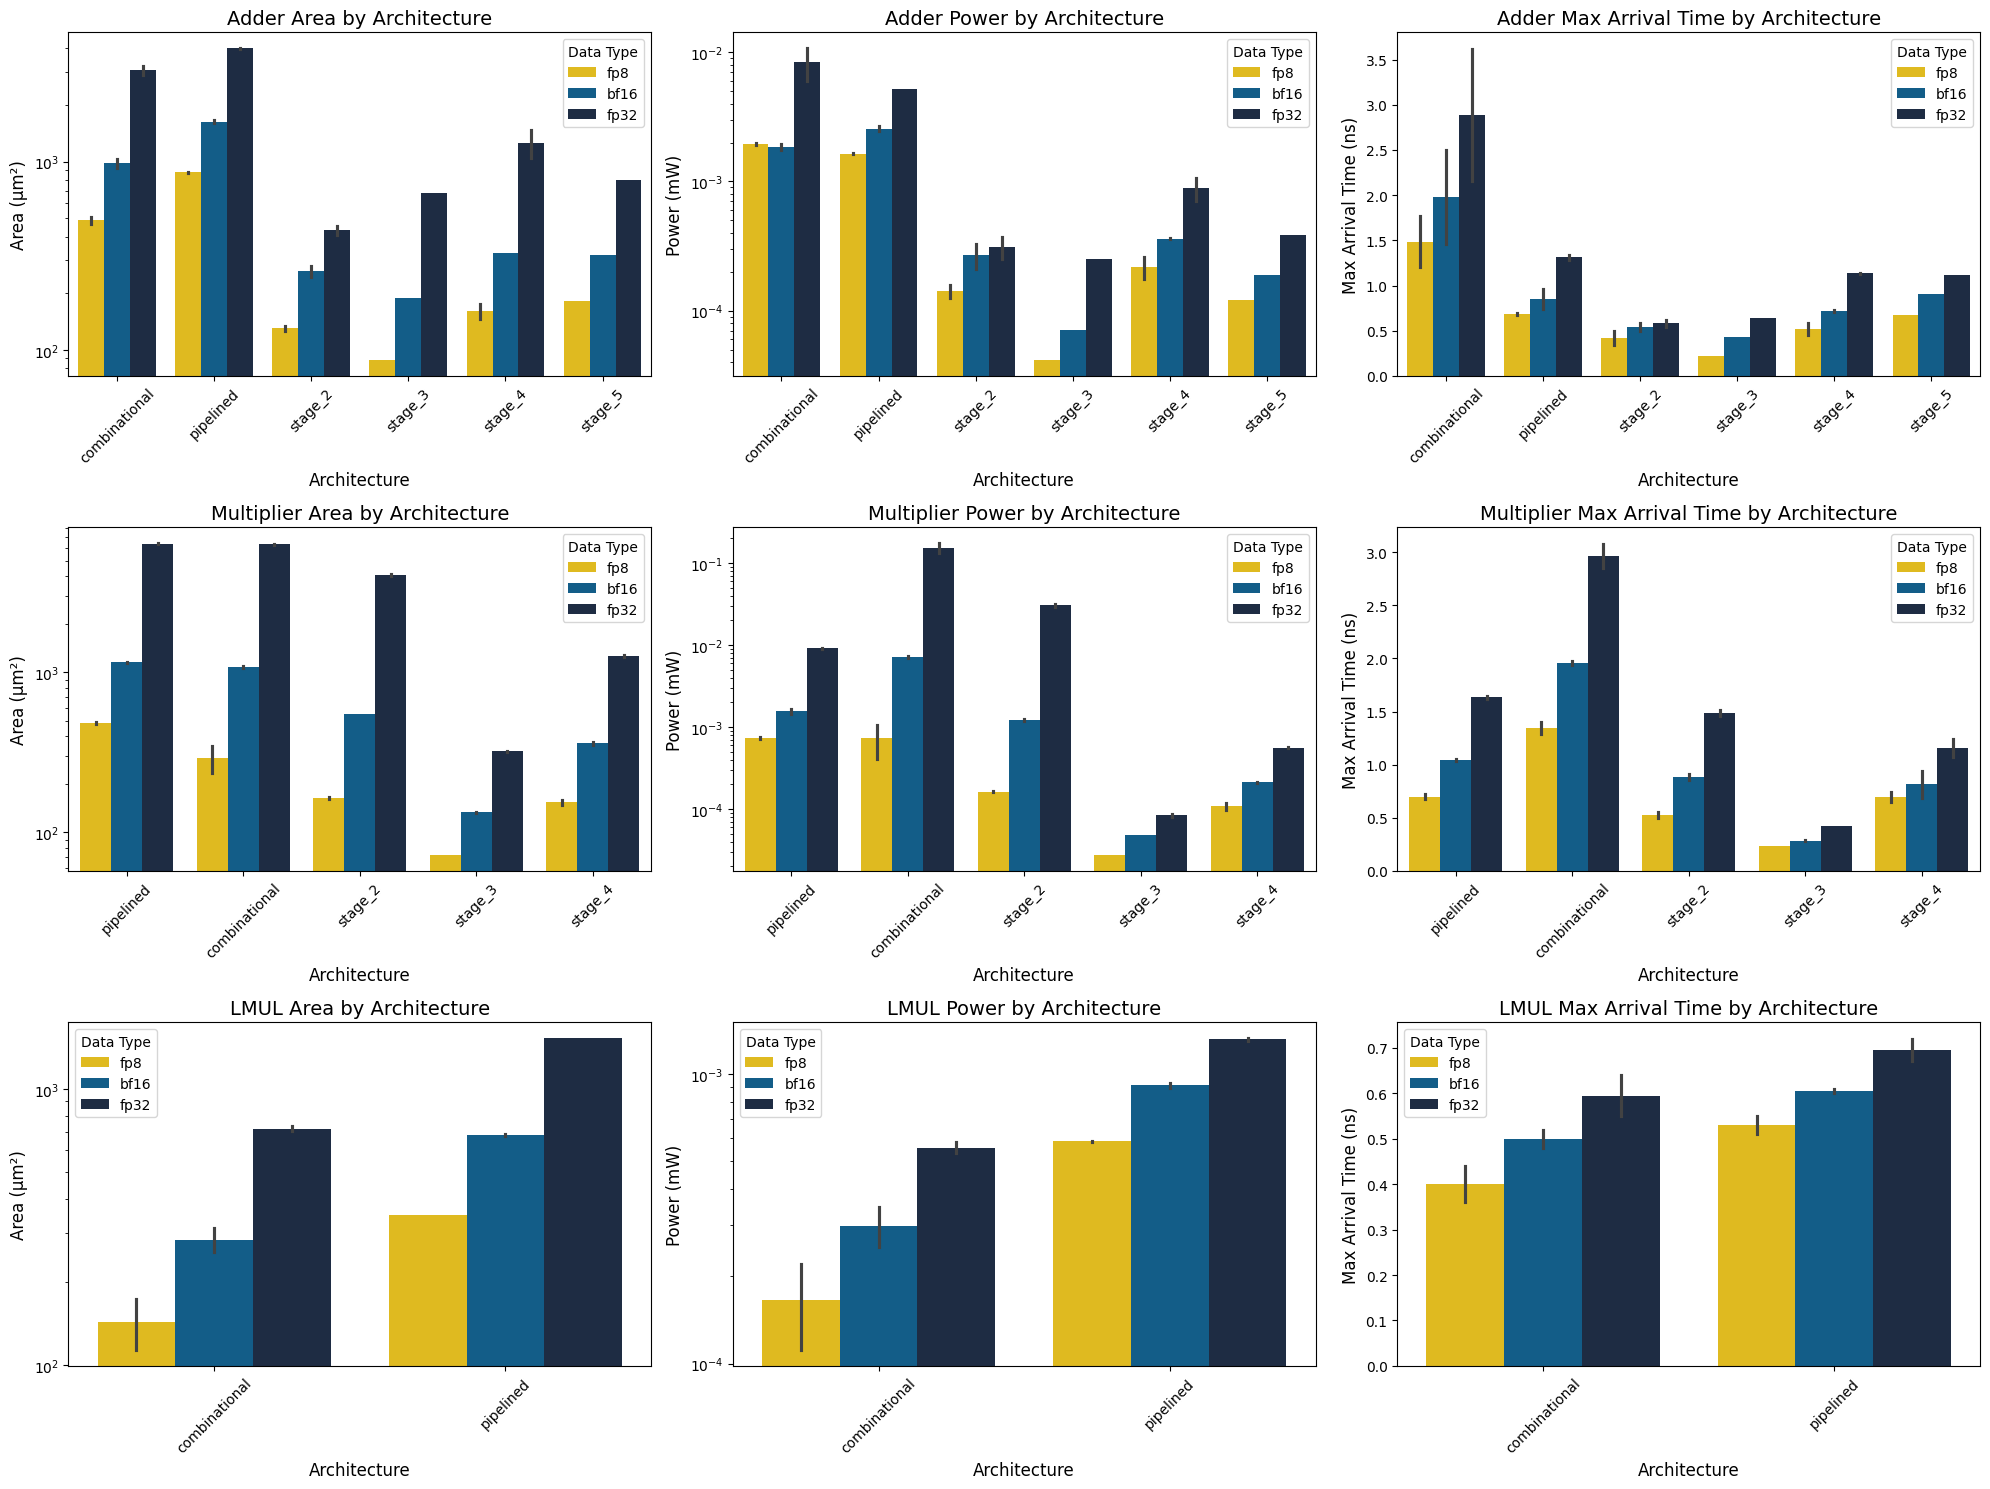

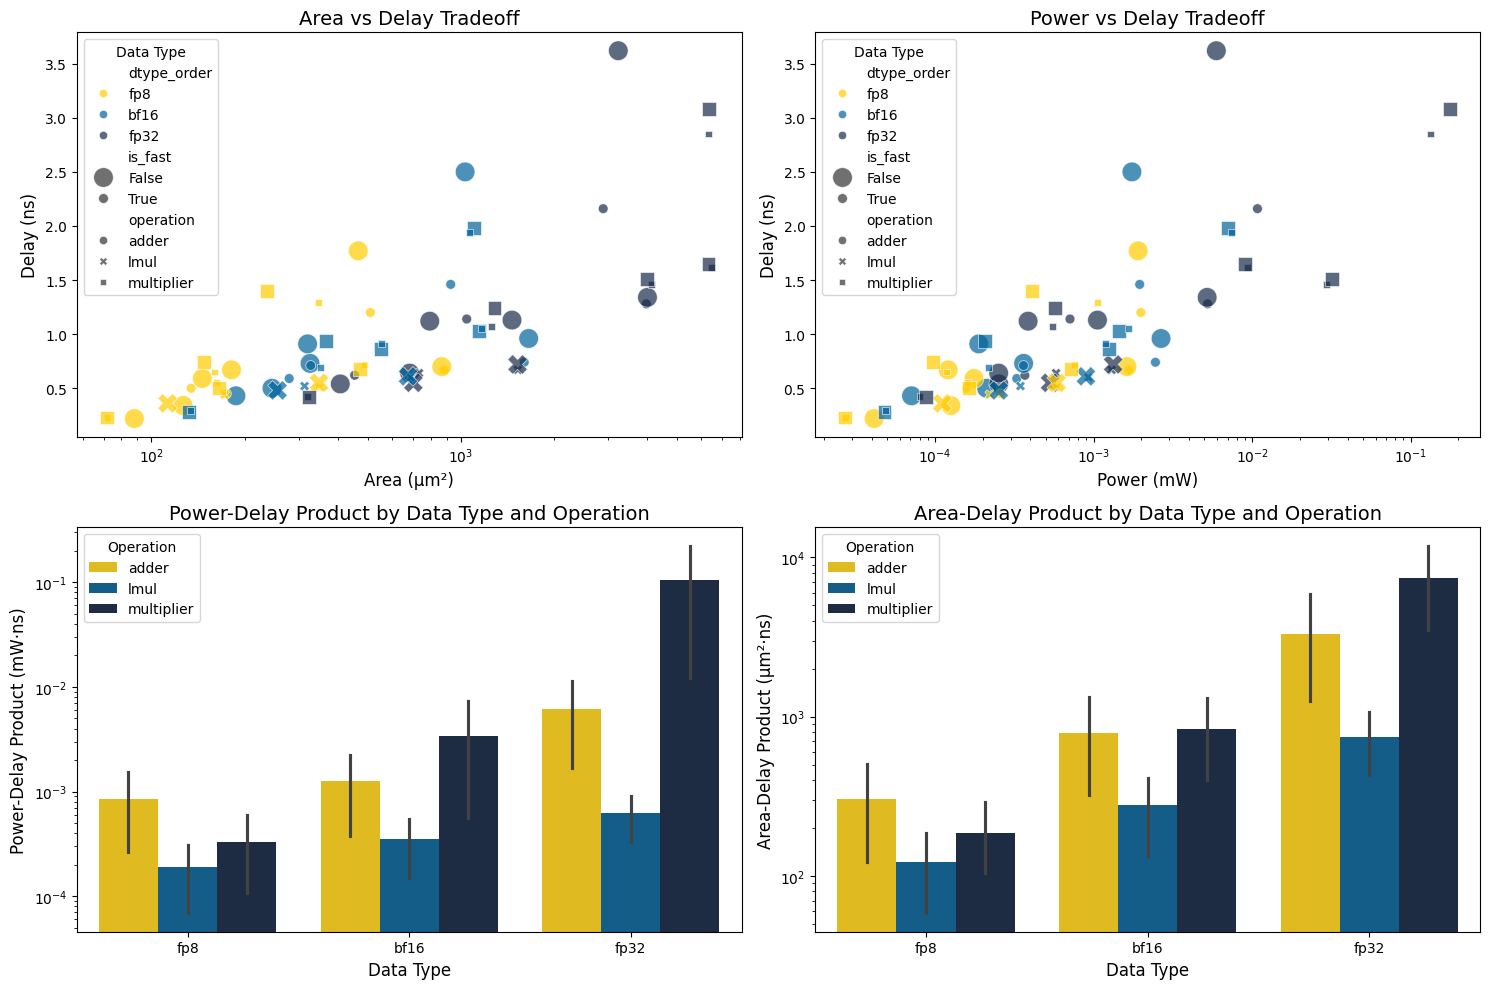


Best Designs by Metric:
                     Metric                       Design         Value
0             Smallest Area  multiplier_stage_3_fast_fp8     71.82 μm²
1              Lowest Power  multiplier_stage_3_fast_fp8       0.00 mW
2            Shortest Delay            adder_stage_3_fp8       0.22 ns
3   Best Area-Delay Product  multiplier_stage_3_fast_fp8  16.52 μm²·ns
4  Best Power-Delay Product  multiplier_stage_3_fast_fp8    0.00 mW·ns


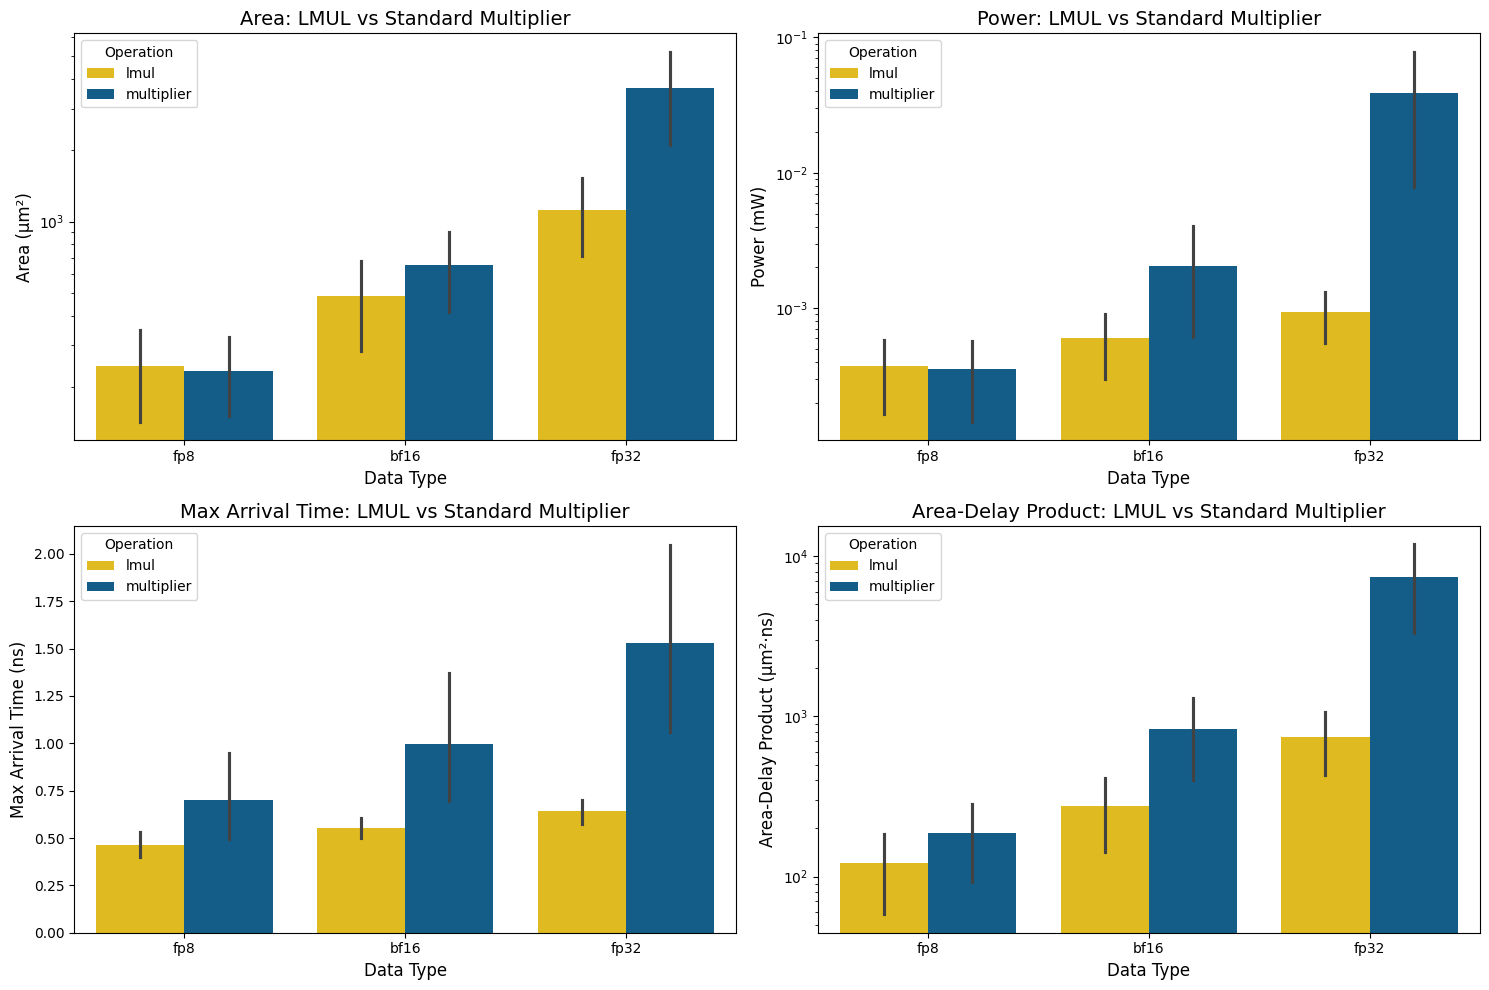

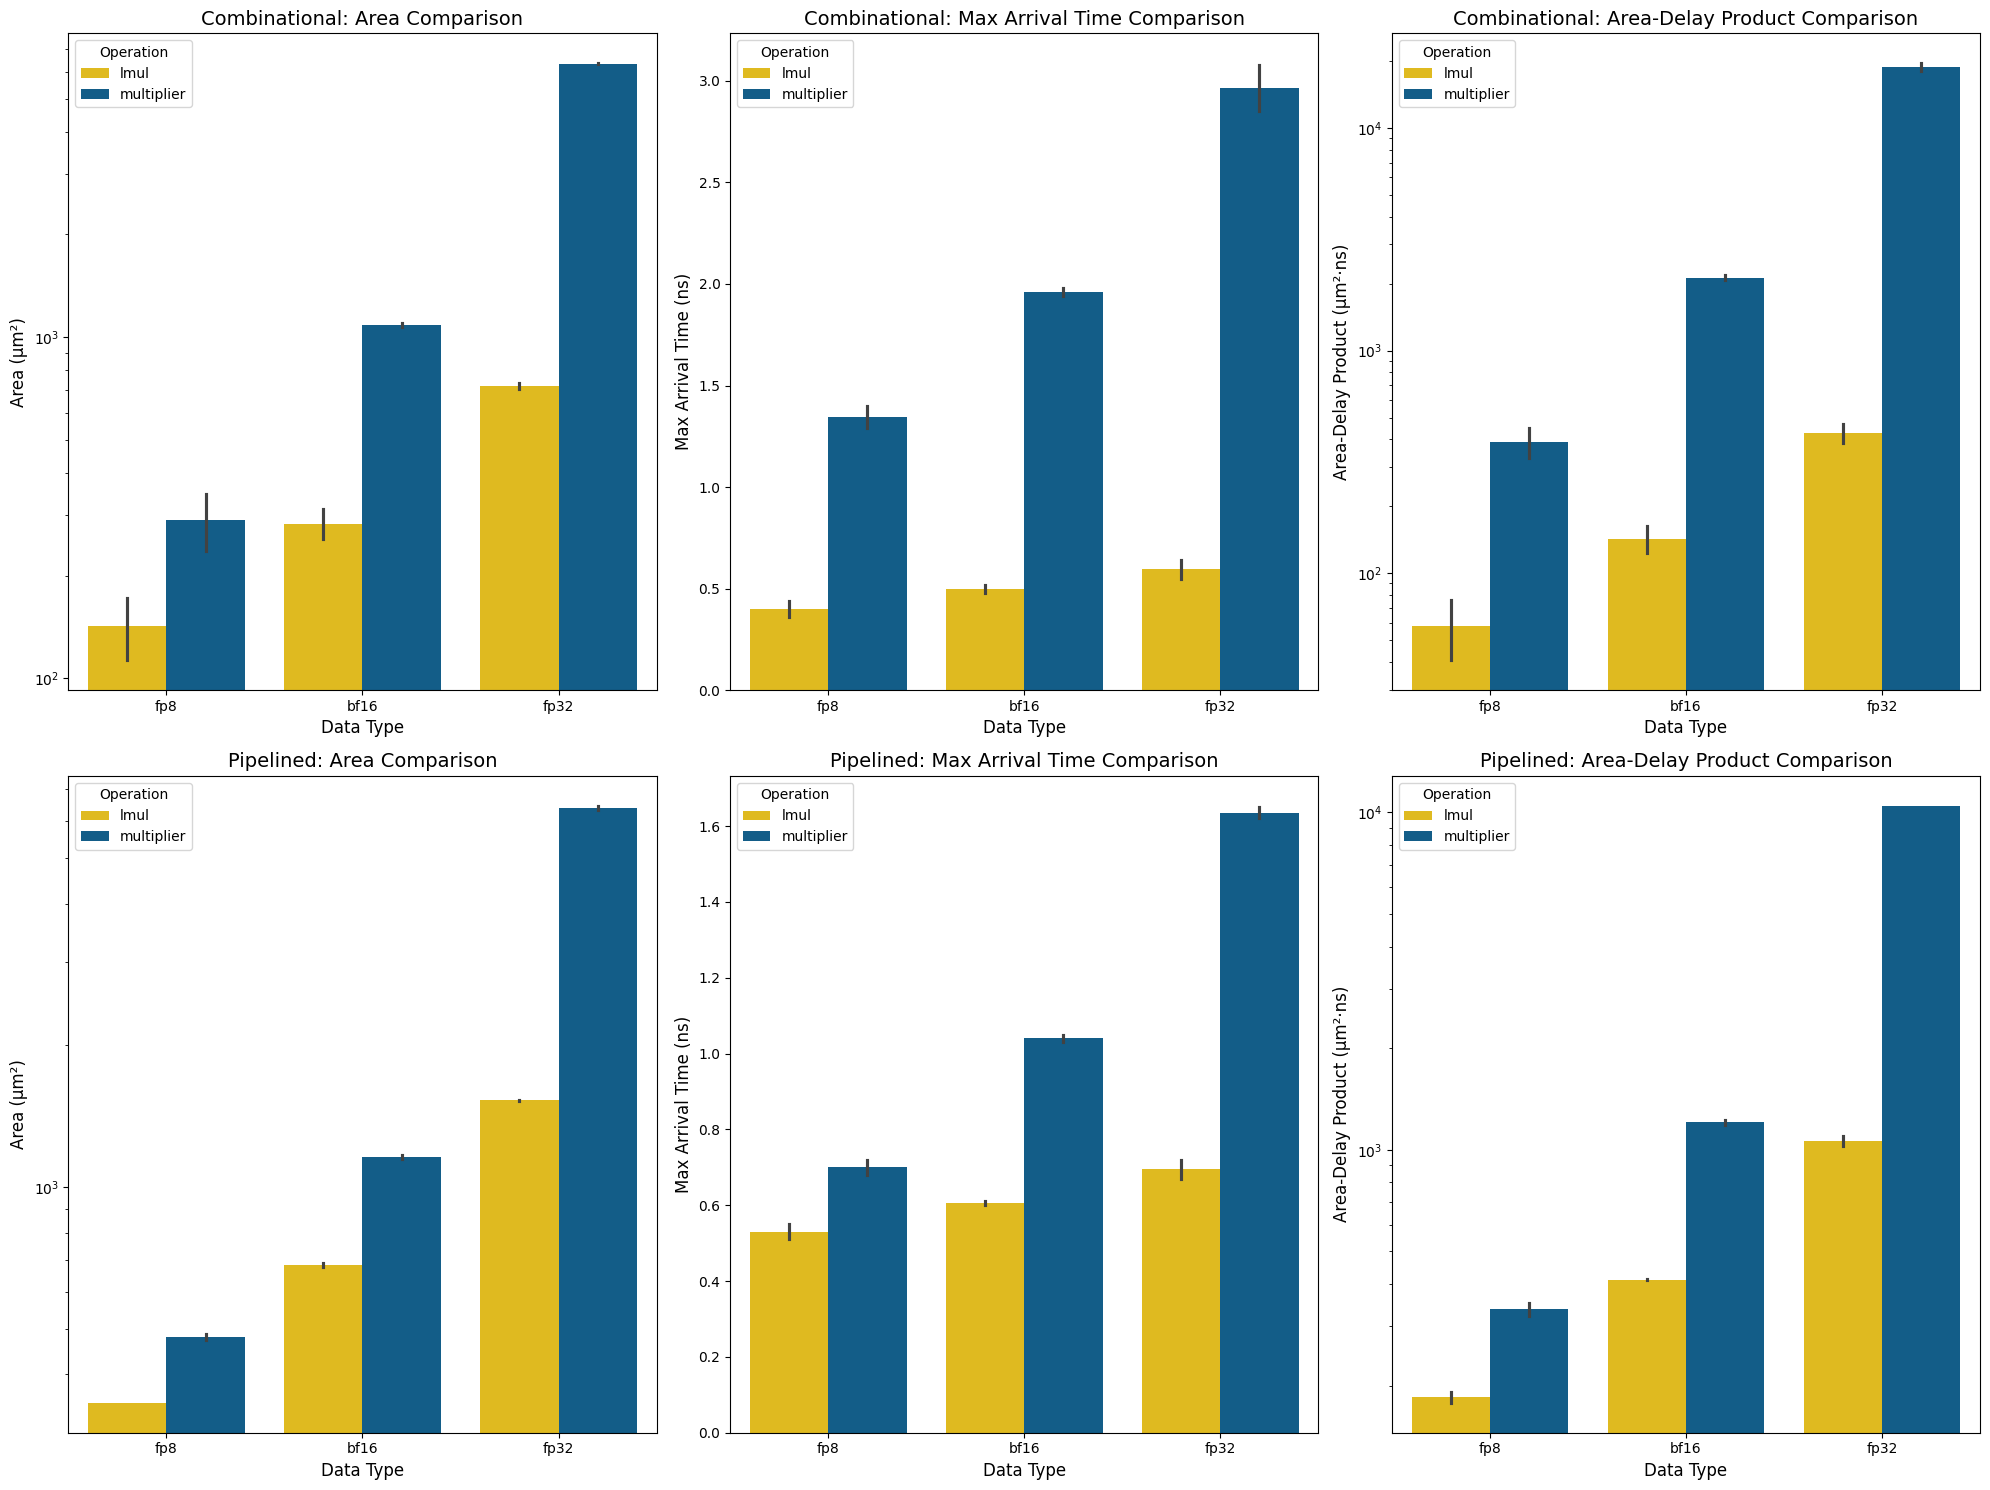


Average Improvement of LMUL over Standard Multiplier:
             Area Improvement (%)  Power Improvement (%)  \
dtype_order                                                
fp8                     -5.630579              -5.988850   
bf16                    26.569847              70.553833   
fp32                    69.481512              97.604657   

             Delay Improvement (%)  ADP Improvement (%)  PDP Improvement (%)  
dtype_order                                                                   
fp8                      33.476395            35.075351            42.742681  
bf16                     44.583751            66.580735            89.729253  
fp32                     57.898172            89.905281            99.404166  


/var/folders/y3/tksyxtt965942c_qjvy325mc0000gn/T/ipykernel_22815/3694059187.py:429: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mult_lmul_df.groupby(["dtype_order", "operation"])


<Figure size 1200x800 with 0 Axes>

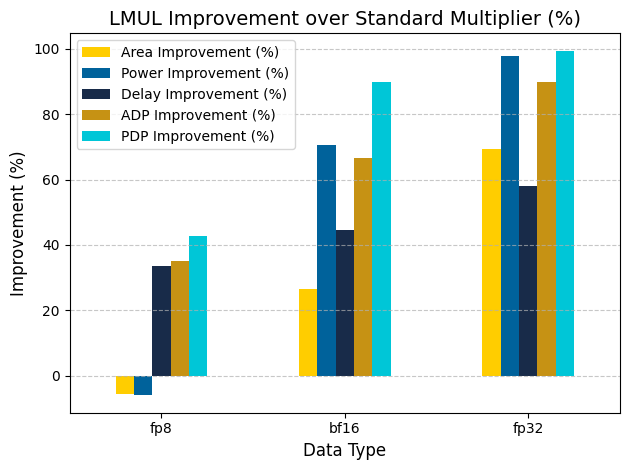

In [54]:
# Create a figure with multiple subplots for visualizations
plt.figure(figsize=(20, 15))

# 1. Area comparison by dtype and operation
plt.subplot(2, 2, 1)
sns.barplot(x="dtype_order", y="area", hue="operation", data=df)
plt.title("Area by Data Type and Operation", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")  # Log scale for better visualization if values vary widely
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 2. Power comparison by dtype and operation
plt.subplot(2, 2, 2)
sns.barplot(x="dtype_order", y="power", hue="operation", data=df)
plt.title("Power by Data Type and Operation", fontsize=14)
plt.ylabel("Power (mW)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")  # Log scale for better visualization if values vary widely
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 3. Max arrival time comparison by dtype and operation
plt.subplot(2, 2, 3)
sns.barplot(x="dtype_order", y="max_arrival_time", hue="operation", data=df)
plt.title("Max Arrival Time by Data Type and Operation", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 4. Area vs Power scatter plot, colored by dtype
plt.subplot(2, 2, 4)
sns.scatterplot(
    x="area", y="power", hue="dtype_order", style="operation", s=100, data=df
)
plt.title("Area vs Power by Data Type and Operation", fontsize=14)
plt.xlabel("Area (μm²)", fontsize=12)
plt.ylabel("Power (mW)", fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.legend(title="Data Type")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "hardware_metrics_overview.png"), dpi=300)
plt.show()

# Create a figure to compare fast vs regular implementations
plt.figure(figsize=(15, 10))

# 1. Area comparison: fast vs regular
plt.subplot(2, 2, 1)
sns.barplot(x="dtype_order", y="area", hue="is_fast", data=df)
plt.title("Area: Fast vs Regular Implementations", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Fast Implementation")

# 2. Power comparison: fast vs regular
plt.subplot(2, 2, 2)
sns.barplot(x="dtype_order", y="power", hue="is_fast", data=df)
plt.title("Power: Fast vs Regular Implementations", fontsize=14)
plt.ylabel("Power (mW)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Fast Implementation")

# 3. Max arrival time comparison: fast vs regular
plt.subplot(2, 2, 3)
sns.barplot(x="dtype_order", y="max_arrival_time", hue="is_fast", data=df)
plt.title("Max Arrival Time: Fast vs Regular Implementations", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Fast Implementation")

# 4. Area-Delay Product (ADP) comparison
df["adp"] = df["area"] * df["max_arrival_time"]
plt.subplot(2, 2, 4)
sns.barplot(x="dtype_order", y="adp", hue="is_fast", data=df)
plt.title("Area-Delay Product: Fast vs Regular Implementations", fontsize=14)
plt.ylabel("Area-Delay Product (μm²·ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Fast Implementation")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "fast_vs_regular_comparison.png"), dpi=300)
plt.show()

# Create a figure to compare different architectures for each operation
plt.figure(figsize=(20, 15))

# Filter for adders only
adders_df = df[df["operation"] == "adder"]

# 1. Area comparison by architecture for adders
plt.subplot(3, 3, 1)
sns.barplot(x="architecture", y="area", hue="dtype_order", data=adders_df)
plt.title("Adder Area by Architecture", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# 2. Power comparison by architecture for adders
plt.subplot(3, 3, 2)
sns.barplot(x="architecture", y="power", hue="dtype_order", data=adders_df)
plt.title("Adder Power by Architecture", fontsize=14)
plt.ylabel("Power (mW)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# 3. Max arrival time comparison by architecture for adders
plt.subplot(3, 3, 3)
sns.barplot(x="architecture", y="max_arrival_time", hue="dtype_order", data=adders_df)
plt.title("Adder Max Arrival Time by Architecture", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# Filter for multipliers only
multipliers_df = df[df["operation"] == "multiplier"]

# 4. Area comparison by architecture for multipliers
plt.subplot(3, 3, 4)
sns.barplot(x="architecture", y="area", hue="dtype_order", data=multipliers_df)
plt.title("Multiplier Area by Architecture", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# 5. Power comparison by architecture for multipliers
plt.subplot(3, 3, 5)
sns.barplot(x="architecture", y="power", hue="dtype_order", data=multipliers_df)
plt.title("Multiplier Power by Architecture", fontsize=14)
plt.ylabel("Power (mW)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# 6. Max arrival time comparison by architecture for multipliers
plt.subplot(3, 3, 6)
sns.barplot(
    x="architecture", y="max_arrival_time", hue="dtype_order", data=multipliers_df
)
plt.title("Multiplier Max Arrival Time by Architecture", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# Filter for lmul only
lmul_df = df[df["operation"] == "lmul"]

# 7. Area comparison by architecture for lmul
plt.subplot(3, 3, 7)
sns.barplot(x="architecture", y="area", hue="dtype_order", data=lmul_df)
plt.title("LMUL Area by Architecture", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# 8. Power comparison by architecture for lmul
plt.subplot(3, 3, 8)
sns.barplot(x="architecture", y="power", hue="dtype_order", data=lmul_df)
plt.title("LMUL Power by Architecture", fontsize=14)
plt.ylabel("Power (mW)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45)
plt.legend(title="Data Type")

# 9. Max arrival time comparison by architecture for lmul
plt.subplot(3, 3, 9)
sns.barplot(x="architecture", y="max_arrival_time", hue="dtype_order", data=lmul_df)
plt.title("LMUL Max Arrival Time by Architecture", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Data Type")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "architecture_comparison_by_operation.png"), dpi=300)
plt.show()

# Create a figure to show the tradeoffs between area, power, and delay
plt.figure(figsize=(15, 10))

# 1. Area vs Delay scatter plot
plt.subplot(2, 2, 1)
sns.scatterplot(
    x="area",
    y="max_arrival_time",
    hue="dtype_order",
    style="operation",
    size="is_fast",
    sizes=(50, 200),
    alpha=0.7,
    data=df,
)
plt.title("Area vs Delay Tradeoff", fontsize=14)
plt.xlabel("Area (μm²)", fontsize=12)
plt.ylabel("Delay (ns)", fontsize=12)
plt.xscale("log")
plt.legend(title="Data Type")

# 2. Power vs Delay scatter plot
plt.subplot(2, 2, 2)
sns.scatterplot(
    x="power",
    y="max_arrival_time",
    hue="dtype_order",
    style="operation",
    size="is_fast",
    sizes=(50, 200),
    alpha=0.7,
    data=df,
)
plt.title("Power vs Delay Tradeoff", fontsize=14)
plt.xlabel("Power (mW)", fontsize=12)
plt.ylabel("Delay (ns)", fontsize=12)
plt.xscale("log")
plt.legend(title="Data Type")

# 3. Power-Delay Product (PDP)
df["pdp"] = df["power"] * df["max_arrival_time"]
plt.subplot(2, 2, 3)
sns.barplot(x="dtype_order", y="pdp", hue="operation", data=df)
plt.title("Power-Delay Product by Data Type and Operation", fontsize=14)
plt.ylabel("Power-Delay Product (mW·ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 4. Area-Delay Product (ADP)
plt.subplot(2, 2, 4)
sns.barplot(x="dtype_order", y="adp", hue="operation", data=df)
plt.title("Area-Delay Product by Data Type and Operation", fontsize=14)
plt.ylabel("Area-Delay Product (μm²·ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "hardware_tradeoffs.png"), dpi=300)
plt.show()

# Create a table with the best designs for each metric
print("\nBest Designs by Metric:")
best_area = df.loc[df["area"].idxmin()]
best_power = df.loc[df["power"].idxmin()]
best_delay = df.loc[df["max_arrival_time"].idxmin()]
best_adp = df.loc[df["adp"].idxmin()]
best_pdp = df.loc[df["pdp"].idxmin()]

best_designs = pd.DataFrame(
    {
        "Metric": [
            "Smallest Area",
            "Lowest Power",
            "Shortest Delay",
            "Best Area-Delay Product",
            "Best Power-Delay Product",
        ],
        "Design": [
            best_area["name"],
            best_power["name"],
            best_delay["name"],
            best_adp["name"],
            best_pdp["name"],
        ],
        "Value": [
            f"{best_area['area']:.2f} μm²",
            f"{best_power['power']:.2f} mW",
            f"{best_delay['max_arrival_time']:.2f} ns",
            f"{best_adp['adp']:.2f} μm²·ns",
            f"{best_pdp['pdp']:.2f} mW·ns",
        ],
    }
)
print(best_designs)

# Compare LMUL vs standard multiplier implementations
plt.figure(figsize=(15, 10))

# Filter for multiplier and lmul operations
mult_lmul_df = df[(df["operation"] == "multiplier") | (df["operation"] == "lmul")]

# 1. Area comparison: LMUL vs standard multiplier
plt.subplot(2, 2, 1)
sns.barplot(x="dtype_order", y="area", hue="operation", data=mult_lmul_df)
plt.title("Area: LMUL vs Standard Multiplier", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 2. Power comparison: LMUL vs standard multiplier
plt.subplot(2, 2, 2)
sns.barplot(x="dtype_order", y="power", hue="operation", data=mult_lmul_df)
plt.title("Power: LMUL vs Standard Multiplier", fontsize=14)
plt.ylabel("Power (mW)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 3. Max arrival time comparison: LMUL vs standard multiplier
plt.subplot(2, 2, 3)
sns.barplot(x="dtype_order", y="max_arrival_time", hue="operation", data=mult_lmul_df)
plt.title("Max Arrival Time: LMUL vs Standard Multiplier", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 4. Area-Delay Product comparison: LMUL vs standard multiplier
plt.subplot(2, 2, 4)
sns.barplot(x="dtype_order", y="adp", hue="operation", data=mult_lmul_df)
plt.title("Area-Delay Product: LMUL vs Standard Multiplier", fontsize=14)
plt.ylabel("Area-Delay Product (μm²·ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "lmul_vs_standard_multiplier.png"), dpi=300)
plt.show()

# Further analyze LMUL vs standard multiplier by architecture type
plt.figure(figsize=(20, 15))

# Filter for combinational architectures
comb_mult_lmul_df = mult_lmul_df[mult_lmul_df["architecture"] == "combinational"]

# 1. Area comparison for combinational architectures
plt.subplot(2, 3, 1)
sns.barplot(x="dtype_order", y="area", hue="operation", data=comb_mult_lmul_df)
plt.title("Combinational: Area Comparison", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 2. Max arrival time comparison for combinational architectures
plt.subplot(2, 3, 2)
sns.barplot(
    x="dtype_order", y="max_arrival_time", hue="operation", data=comb_mult_lmul_df
)
plt.title("Combinational: Max Arrival Time Comparison", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 3. ADP comparison for combinational architectures
plt.subplot(2, 3, 3)
sns.barplot(x="dtype_order", y="adp", hue="operation", data=comb_mult_lmul_df)
plt.title("Combinational: Area-Delay Product Comparison", fontsize=14)
plt.ylabel("Area-Delay Product (μm²·ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

# Filter for pipelined architectures
pipe_mult_lmul_df = mult_lmul_df[mult_lmul_df["architecture"] == "pipelined"]

# 4. Area comparison for pipelined architectures
plt.subplot(2, 3, 4)
sns.barplot(x="dtype_order", y="area", hue="operation", data=pipe_mult_lmul_df)
plt.title("Pipelined: Area Comparison", fontsize=14)
plt.ylabel("Area (μm²)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 5. Max arrival time comparison for pipelined architectures
plt.subplot(2, 3, 5)
sns.barplot(
    x="dtype_order", y="max_arrival_time", hue="operation", data=pipe_mult_lmul_df
)
plt.title("Pipelined: Max Arrival Time Comparison", fontsize=14)
plt.ylabel("Max Arrival Time (ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Operation")

# 6. ADP comparison for pipelined architectures
plt.subplot(2, 3, 6)
sns.barplot(x="dtype_order", y="adp", hue="operation", data=pipe_mult_lmul_df)
plt.title("Pipelined: Area-Delay Product Comparison", fontsize=14)
plt.ylabel("Area-Delay Product (μm²·ns)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=0)
plt.legend(title="Operation")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "lmul_vs_multiplier_by_architecture.png"), dpi=300)
plt.show()

# Calculate and display average improvement of LMUL over standard multiplier
print("\nAverage Improvement of LMUL over Standard Multiplier:")

# Group by dtype and operation
grouped = (
    mult_lmul_df.groupby(["dtype_order", "operation"])
    .agg(
        {
            "area": "mean",
            "power": "mean",
            "max_arrival_time": "mean",
            "adp": "mean",
            "pdp": "mean",
        }
    )
    .reset_index()
)

# Pivot to get multiplier and lmul side by side
pivot_area = grouped.pivot(index="dtype_order", columns="operation", values="area")
pivot_power = grouped.pivot(index="dtype_order", columns="operation", values="power")
pivot_delay = grouped.pivot(
    index="dtype_order", columns="operation", values="max_arrival_time"
)
pivot_adp = grouped.pivot(index="dtype_order", columns="operation", values="adp")
pivot_pdp = grouped.pivot(index="dtype_order", columns="operation", values="pdp")

# Calculate percentage improvement
area_improvement = (1 - pivot_area["lmul"] / pivot_area["multiplier"]) * 100
power_improvement = (1 - pivot_power["lmul"] / pivot_power["multiplier"]) * 100
delay_improvement = (1 - pivot_delay["lmul"] / pivot_delay["multiplier"]) * 100
adp_improvement = (1 - pivot_adp["lmul"] / pivot_adp["multiplier"]) * 100
pdp_improvement = (1 - pivot_pdp["lmul"] / pivot_pdp["multiplier"]) * 100

# Create a DataFrame with the improvements
improvements = pd.DataFrame(
    {
        "Area Improvement (%)": area_improvement,
        "Power Improvement (%)": power_improvement,
        "Delay Improvement (%)": delay_improvement,
        "ADP Improvement (%)": adp_improvement,
        "PDP Improvement (%)": pdp_improvement,
    }
)

print(improvements)

# Save the improvements to a CSV file
improvements.to_csv(os.path.join(SAVE_DIR, "lmul_vs_multiplier_improvements.csv"))

# Create a bar chart showing the improvements
plt.figure(figsize=(12, 8))
improvements.plot(kind="bar", rot=0)
plt.title("LMUL Improvement over Standard Multiplier (%)", fontsize=14)
plt.ylabel("Improvement (%)", fontsize=12)
plt.xlabel("Data Type", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "lmul_improvement_percentage.png"), dpi=300)
plt.show()

/var/folders/y3/tksyxtt965942c_qjvy325mc0000gn/T/ipykernel_22815/1018450022.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = fast_pipelined_df.groupby(['dtype_order', 'operation']).agg({


<Figure size 1600x1000 with 0 Axes>

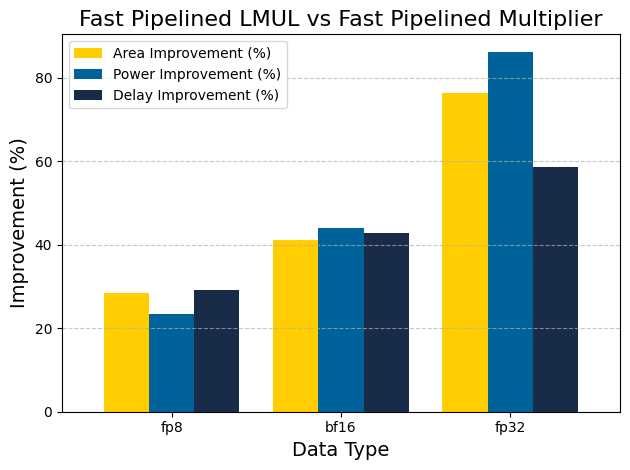

In [ ]:
# Filter for fast pipelined multiplier and lmul implementations
fast_pipelined_mask = (
    df["name"].str.contains("multiplier_pipelined") & df["name"].str.contains("fast")
) | (df["name"].str.contains("lmul_pipelined") & df["name"].str.contains("fast"))
fast_pipelined_df = df[fast_pipelined_mask].copy()

# Group by dtype and operation
grouped = (
    fast_pipelined_df.groupby(["dtype_order", "operation"])
    .agg({"area": "mean", "power": "mean", "max_arrival_time": "mean"})
    .reset_index()
)

# Pivot to get multiplier and lmul side by side
pivot_area = grouped.pivot(index="dtype_order", columns="operation", values="area")
pivot_power = grouped.pivot(index="dtype_order", columns="operation", values="power")
pivot_delay = grouped.pivot(
    index="dtype_order", columns="operation", values="max_arrival_time"
)

# Calculate percentage improvement
area_improvement = (1 - pivot_area["lmul"] / pivot_area["multiplier"]) * 100
power_improvement = (1 - pivot_power["lmul"] / pivot_power["multiplier"]) * 100
delay_improvement = (1 - pivot_delay["lmul"] / pivot_delay["multiplier"]) * 100

# Create a DataFrame with the improvements
improvements = pd.DataFrame(
    {
        "Area Improvement (%)": area_improvement,
        "Power Improvement (%)": power_improvement,
        "Delay Improvement (%)": delay_improvement,
    }
)

# Create a DataFrame with absolute values for labeling
abs_values = pd.DataFrame(
    {
        "Area (LMUL)": pivot_area["lmul"],
        "Area (Mult)": pivot_area["multiplier"],
        "Power (LMUL)": pivot_power["lmul"],
        "Power (Mult)": pivot_power["multiplier"],
        "Delay (LMUL)": pivot_delay["lmul"],
        "Delay (Mult)": pivot_delay["multiplier"],
    }
)

# Create the visualization
plt.figure(figsize=(16, 10))
ax = improvements.plot(kind="bar", rot=0, width=0.8)
plt.title("Fast Pipelined LMUL vs Fast Pipelined Multiplier", fontsize=16)
plt.ylabel("Improvement (%)", fontsize=14)
plt.xlabel("Data Type", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add value labels on bars
for i, p in enumerate(ax.patches):
    # Calculate the position for the text
    height = p.get_height()
    x_pos = p.get_x() + p.get_width() / 2
    y_pos = height + 1 if height > 0 else height - 5

    # Determine which metric and dtype we're looking at
    metric_idx = i // len(improvements)
    dtype_idx = i % len(improvements)

    # Get the corresponding absolute values
    if metric_idx == 0:  # Area
        lmul_val = abs_values["Area (LMUL)"].iloc[dtype_idx]
        mult_val = abs_values["Area (Mult)"].iloc[dtype_idx]
        label = f"{height:.1f}%\n({lmul_val:.0f} vs {mult_val:.0f} μm²)"
    elif metric_idx == 1:  # Power
        lmul_val = abs_values["Power (LMUL)"].iloc[dtype_idx]
        mult_val = abs_values["Power (Mult)"].iloc[dtype_idx]
        label = f"{height:.1f}%\n({lmul_val:.2f} vs {mult_val:.2f} mW)"
    else:  # Delay
        lmul_val = abs_values["Delay (LMUL)"].iloc[dtype_idx]
        mult_val = abs_values["Delay (Mult)"].iloc[dtype_idx]
        label = f"{height:.1f}%\n({lmul_val:.2f} vs {mult_val:.2f} ns)"

    # Add the text
    # ax.text(x_pos, y_pos, label, ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(
    os.path.join(SAVE_DIR, "fast_pipelined_lmul_vs_multiplier_no_label.png"), dpi=700
)
plt.show()

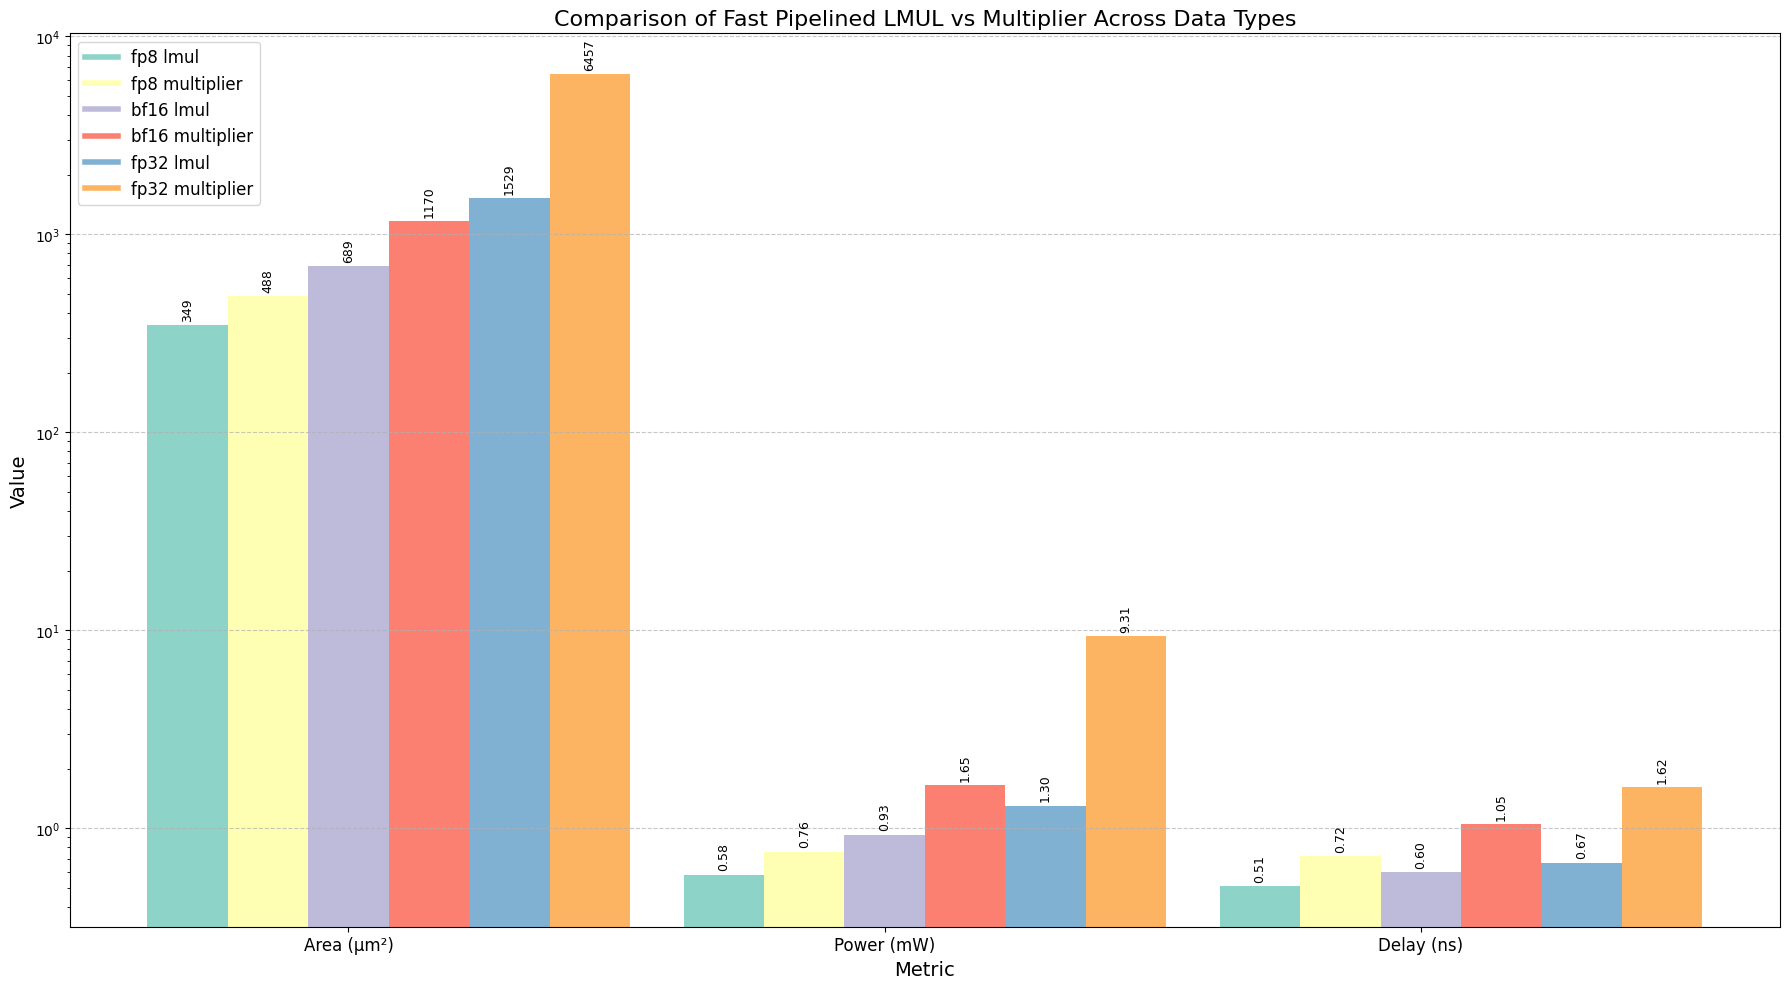

In [ ]:
# Filter for fast pipelined multiplier and lmul implementations
fast_pipelined_mask = (
    df["name"].str.contains("multiplier_pipelined") & df["name"].str.contains("fast")
) | (df["name"].str.contains("lmul_pipelined") & df["name"].str.contains("fast"))
fast_pipelined_df = df[fast_pipelined_mask].copy()
fast_pipelined_df["power"] *= 1000  # Convert power to mW

# Prepare data for grouped bar chart
# Melt the dataframe to have metrics as a variable
melted_df = pd.melt(
    fast_pipelined_df,
    id_vars=["name", "dtype_order", "operation"],
    value_vars=["area", "power", "max_arrival_time"],
    var_name="metric",
    value_name="value",
)

# Map metric names to more readable labels
metric_labels = {
    "area": "Area (μm²)",
    "power": "Power (mW)",
    "max_arrival_time": "Delay (ns)",
}
melted_df["metric"] = melted_df["metric"].map(metric_labels)

# Create the grouped bar chart
plt.figure(figsize=(18, 10))

# Define custom colors for better visibility
colors = {
    "fp8": {"lmul": "#8dd3c7", "multiplier": "#ffffb3"},
    "bf16": {"lmul": "#bebada", "multiplier": "#fb8072"},
    "fp32": {"lmul": "#80b1d3", "multiplier": "#fdb462"},
}

# Set the positions for the bars
metrics = list(metric_labels.values())
n_metrics = len(metrics)
n_dtypes = 3
bar_width = 0.15
index = np.arange(n_metrics)

# Plot bars for each dtype and operation
for i, dtype in enumerate(["fp8", "bf16", "fp32"]):
    for j, op in enumerate(["lmul", "multiplier"]):
        # Filter data for this dtype and operation
        data = melted_df[
            (melted_df["dtype_order"] == dtype) & (melted_df["operation"] == op)
        ]

        # Calculate position for this set of bars
        pos = index - 0.3 + (i * 2 + j) * bar_width

        # Get values for each metric
        values = []
        for metric in metrics:
            val = data[data["metric"] == metric]["value"].mean()
            values.append(val)

        # Plot the bars
        bars = plt.bar(
            pos, values, bar_width, label=f"{dtype} {op}", color=colors[dtype][op]
        )

        # Add value labels on top of bars
        for k, bar in enumerate(bars):
            height = bar.get_height()
            if metrics[k] == "Area (μm²)":
                label = f"{height:.0f}"
            else:
                label = f"{height:.2f}"
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.05 * height,
                label,
                ha="center",
                va="bottom",
                fontsize=9,
                rotation=90,
            )

# Customize the plot
plt.xlabel("Metric", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title(
    "Comparison of Fast Pipelined LMUL vs Multiplier Across Data Types", fontsize=16
)
plt.xticks(index, metrics, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Create a custom legend
from matplotlib.lines import Line2D

legend_elements = []
for dtype in ["fp8", "bf16", "fp32"]:
    for op in ["lmul", "multiplier"]:
        legend_elements.append(
            Line2D([0], [0], color=colors[dtype][op], lw=4, label=f"{dtype} {op}")
        )
plt.legend(handles=legend_elements, loc="upper left", fontsize=12)

# Use log scale for y-axis since area values might be much larger than others
plt.yscale("log")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "fast_pipelined_absolute_comparison.png"), dpi=300)
plt.show()

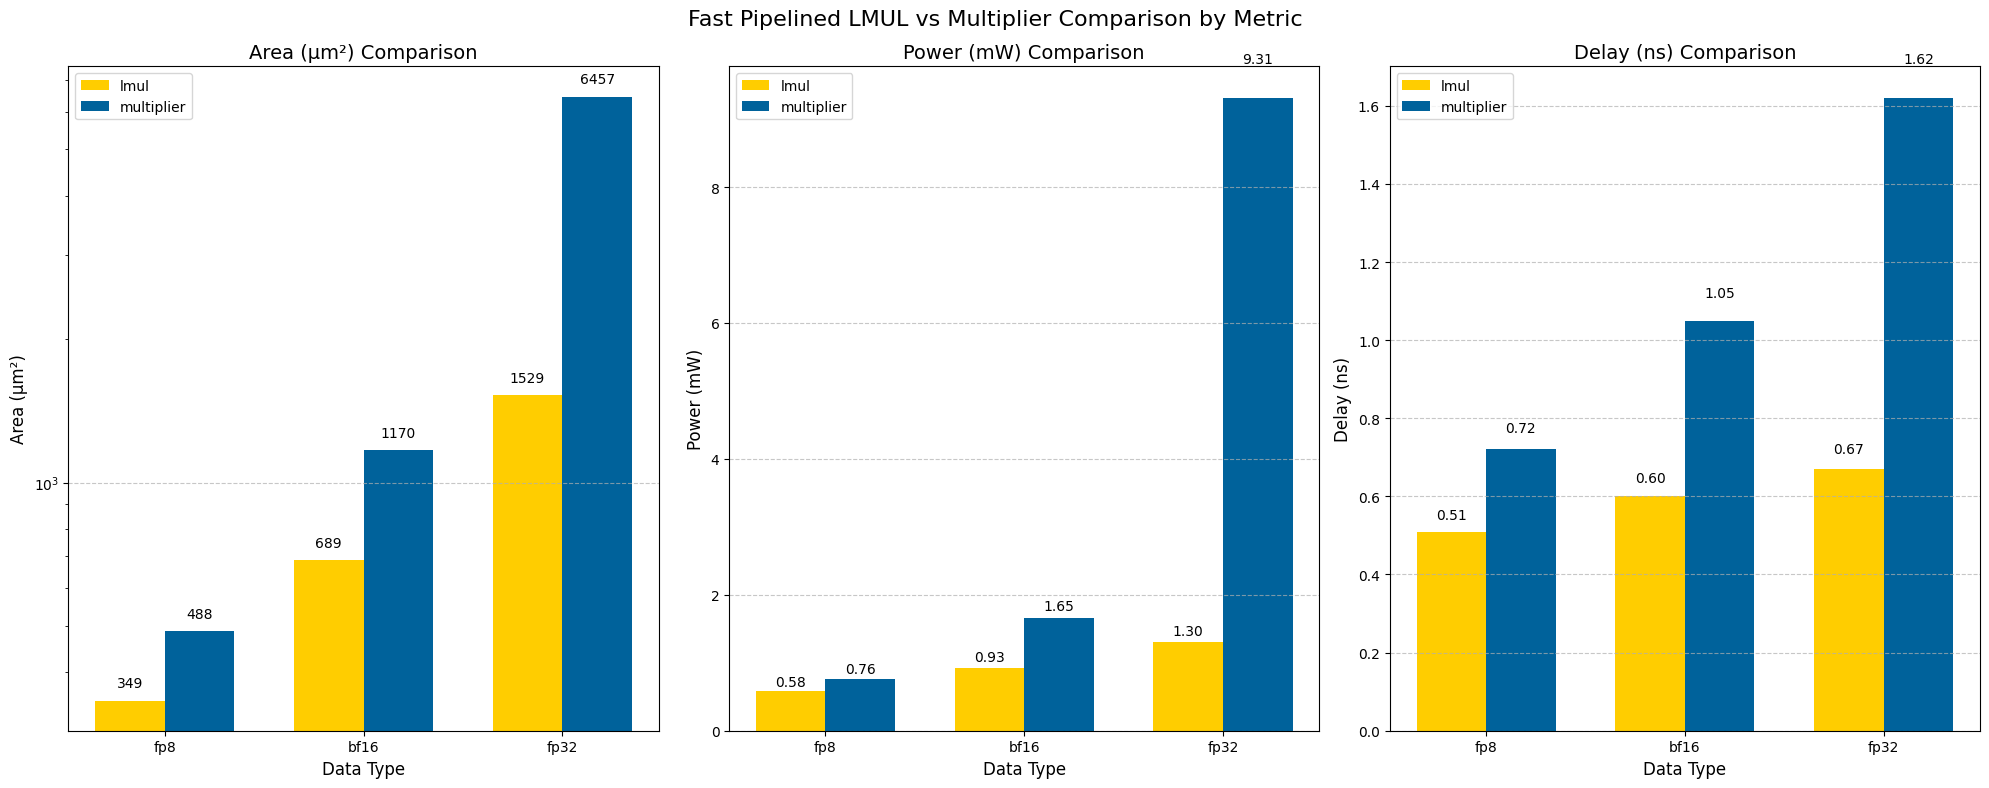

In [ ]:
# Create a second version with separate subplots for each metric for better readability
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

metrics = list(metric_labels.values())
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for this metric
    metric_data = melted_df[melted_df["metric"] == metric]

    # Set positions for bars
    n_groups = 3  # fp8, bf16, fp32
    index = np.arange(n_groups)
    bar_width = 0.35

    # Plot bars for lmul and multiplier
    for j, op in enumerate(["lmul", "multiplier"]):
        # Filter data for this operation
        op_data = metric_data[metric_data["operation"] == op]

        # Get values for each dtype
        values = []
        for dtype in ["fp8", "bf16", "fp32"]:
            val = op_data[op_data["dtype_order"] == dtype]["value"].mean()
            values.append(val)

        # Plot the bars
        pos = index + (j - 0.5) * bar_width
        bars = ax.bar(pos, values, bar_width, label=op)

        # Add value labels
        for k, bar in enumerate(bars):
            height = bar.get_height()
            if metric == "Area (μm²)":
                label = f"{height:.0f}"
            else:
                label = f"{height:.2f}"
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.05 * height,
                label,
                ha="center",
                va="bottom",
                fontsize=10,
            )

    # Customize subplot
    ax.set_xlabel("Data Type", fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f"{metric} Comparison", fontsize=14)
    ax.set_xticks(index)
    ax.set_xticklabels(["fp8", "bf16", "fp32"])
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend()

    # Use log scale for area plot
    if metric == "Area (μm²)":
        ax.set_yscale("log")

plt.suptitle("Fast Pipelined LMUL vs Multiplier Comparison by Metric", fontsize=16)
plt.tight_layout()
plt.savefig(
    os.path.join(SAVE_DIR, "fast_pipelined_absolute_comparison_by_metric.png"), dpi=300
)
plt.show()

fp8 colors: lmul = #F3E500, multiplier= #00C6D7
bf16 colors: lmul = #FFCD00, multiplier= #00629B
fp32 colors: lmul = #C69214, multiplier= #182B49


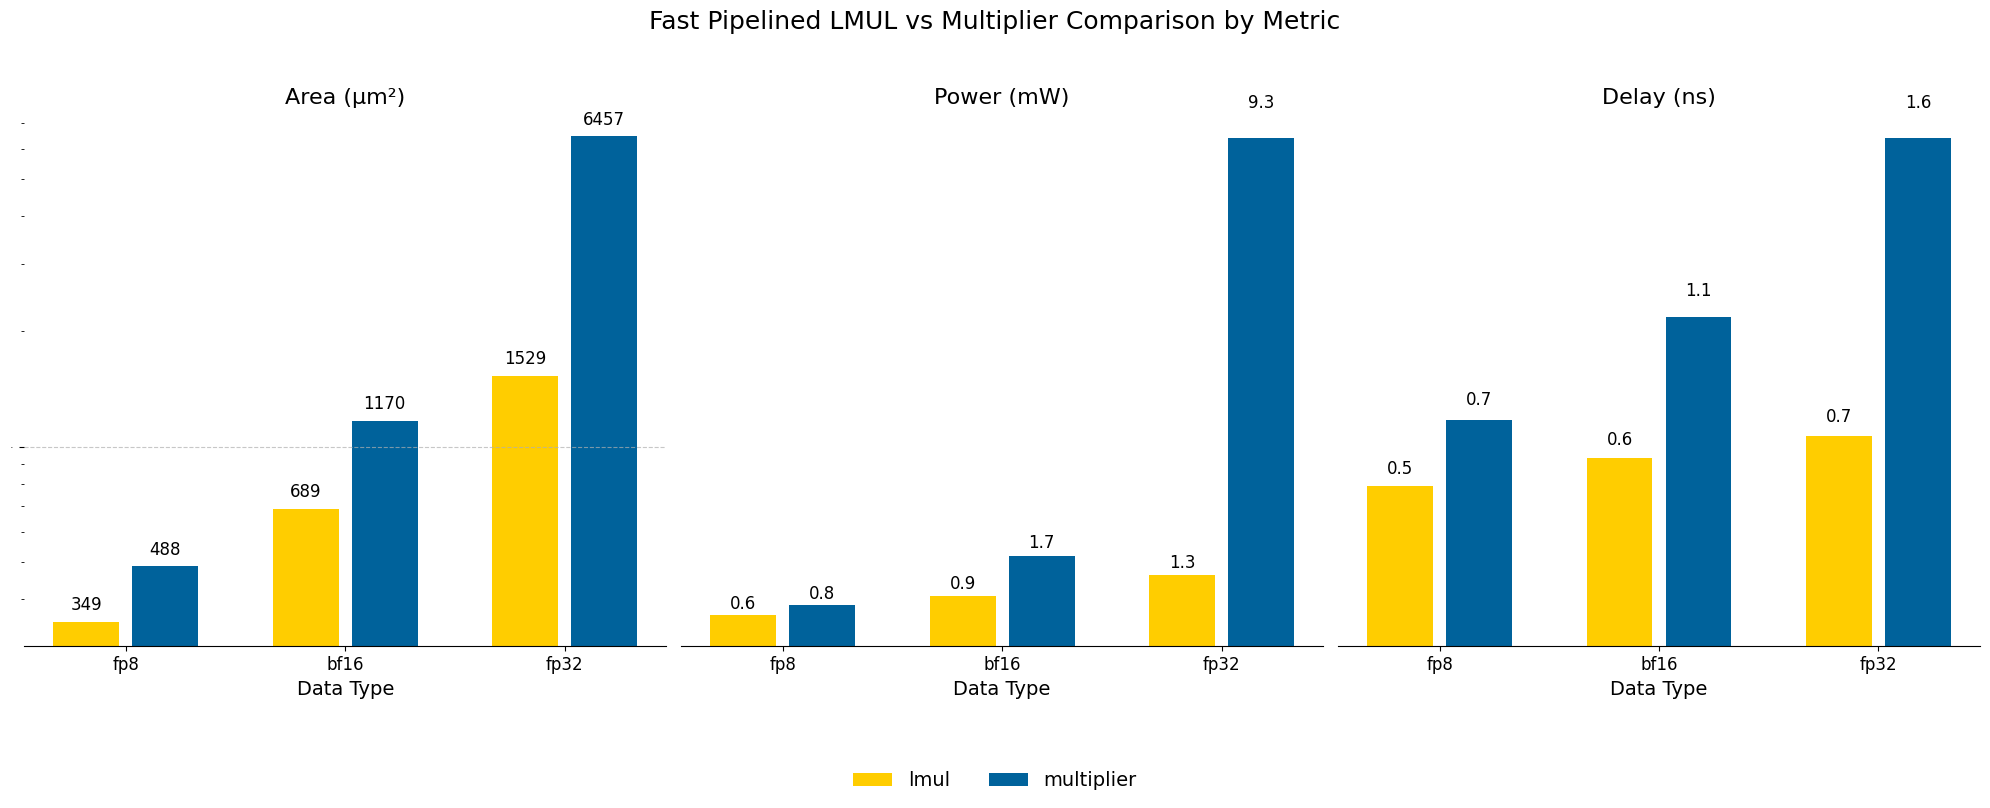

In [ ]:
# Create a second version with separate subplots for each metric for better readability
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Define custom colors as specified
colors = {
    # 'fp8': {'lmul': '#F3E500', 'multiplier': '#00C6D7'},
    "fp8": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    "bf16": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    "fp32": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    # 'fp32': {'lmul': '#C69214', 'multiplier': '#182B49'}
}

metrics = list(metric_labels.values())
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for this metric
    metric_data = melted_df[melted_df["metric"] == metric]

    # Set positions for bars
    n_groups = 3  # fp8, bf16, fp32
    index = np.arange(n_groups)
    bar_width = 0.3  # Slightly narrower bars to add spacing

    # Plot bars for lmul and multiplier
    for j, op in enumerate(["lmul", "multiplier"]):
        # Filter data for this operation
        op_data = metric_data[metric_data["operation"] == op]

        # Get values for each dtype
        values = []
        colors_list = []
        for k, dtype in enumerate(["fp8", "bf16", "fp32"]):
            val = op_data[op_data["dtype_order"] == dtype]["value"].mean()
            values.append(val)
            colors_list.append(colors[dtype][op])

        # Plot the bars with spacing between bars in the same group
        pos = index + (j - 0.5) * bar_width * 1.2  # Add 20% spacing between bars
        bars = ax.bar(
            pos, values, bar_width, label=op if i == 0 else "", color=colors_list
        )

        # Add value labels
        for k, bar in enumerate(bars):
            height = bar.get_height()
            if metric == "Area (μm²)":
                label = f"{height:.0f}"
            elif metric == "Power (mW)":
                label = f"{height:.1f}"
            else:  # Frequency
                label = f"{height:.1f}"
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.05 * height,
                label,
                ha="center",
                va="bottom",
                fontsize=12,
            )

    # Customize subplot
    ax.set_xlabel("Data Type", fontsize=14)
    ax.set_title(f"{metric}", fontsize=16)
    ax.set_xticks(index)
    ax.set_xticklabels(["fp8", "bf16", "fp32"], fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Remove y-axis entirely
    ax.set_ylabel("")
    ax.set_yticks([])

    # Remove all borders
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)

    # Use log scale for area plot (even though y-axis is hidden)
    if metric == "Area (μm²)":
        ax.set_yscale("log")

    # Increase tick label font size
    ax.tick_params(axis="x", which="major", labelsize=12)
    ax.tick_params(axis="y", which="major", labelsize=0)  # Hide y-tick labels

# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    fontsize=14,
    ncol=2,
    frameon=False,
)

plt.suptitle("Fast Pipelined LMUL vs Multiplier Comparison by Metric", fontsize=18)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to make room for the legend
plt.savefig(
    os.path.join(SAVE_DIR, "fast_pipelined_absolute_comparison_by_metric.png"), dpi=300
)
plt.show()

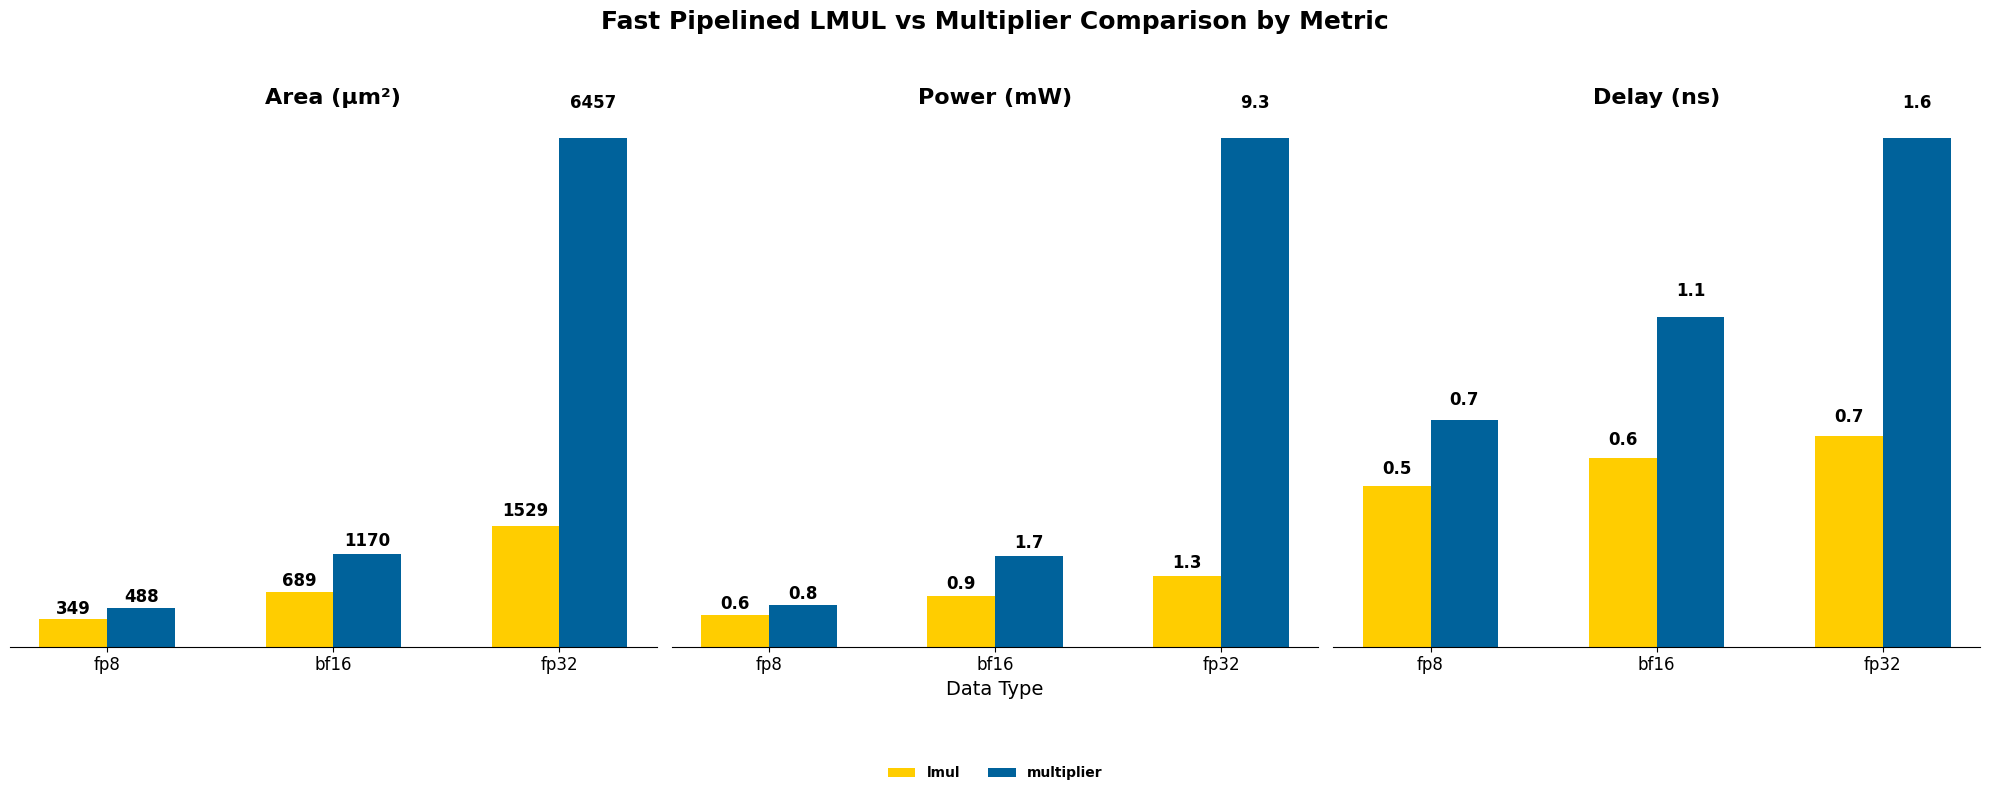

In [ ]:
# Create a second version with separate subplots for each metric for better readability
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Define custom colors as specified
colors = {
    # 'fp8': {'lmul': '#F3E500', 'multiplier': '#00C6D7'},
    "fp8": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    "bf16": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    "fp32": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    # 'fp32': {'lmul': '#C69214', 'multiplier': '#182B49'}
}
metrics = list(metric_labels.values())
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for this metric
    metric_data = melted_df[melted_df["metric"] == metric]

    # Set positions for bars
    n_groups = 3  # fp8, bf16, fp32
    index = np.arange(n_groups)
    bar_width = 0.3  # Slightly narrower bars to add spacing

    # Plot bars for lmul and multiplier
    for j, op in enumerate(["lmul", "multiplier"]):
        # Filter data for this operation
        op_data = metric_data[metric_data["operation"] == op]

        # Get values for each dtype
        values = []
        colors_list = []
        for k, dtype in enumerate(["fp8", "bf16", "fp32"]):
            val = op_data[op_data["dtype_order"] == dtype]["value"].mean()
            values.append(val)
            colors_list.append(colors[dtype][op])

        # Plot the bars with spacing between bars in the same group
        pos = index + (j - 0.5) * bar_width  # * 1.2  # Add 20% spacing between bars
        bars = ax.bar(
            pos, values, bar_width, label=op if i == 0 else "", color=colors_list
        )

        # Add value labels with bold font
        for k, bar in enumerate(bars):
            height = bar.get_height()
            if metric == "Area (μm²)":
                label = f"{height:.0f}"
            elif metric == "Power (mW)":
                label = f"{height:.1f}"
            else:  # Frequency
                label = f"{height:.1f}"
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.05 * height,
                label,
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold",
            )

    # Customize subplot with bold fonts
    if i == 1:
        ax.set_xlabel("Data Type", fontsize=14)
    ax.set_title(f"{metric}", fontsize=16, fontweight="bold")
    ax.set_xticks(index)
    ax.set_xticklabels(["fp8", "bf16", "fp32"], fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Remove y-axis entirely
    ax.set_ylabel("")
    ax.set_yticks([])

    # Remove ALL borders/spines for every subplot
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)

    # Add back just the bottom spine
    ax.spines["bottom"].set_visible(True)

    # Use log scale for area plot (even though y-axis is hidden)
    # if metric == "Area (μm²)":
    # ax.set_yscale("log")

    # Increase tick label font size and make bold
    ax.tick_params(axis="x", which="major", labelsize=12)
    ax.tick_params(axis="y", which="major", labelsize=0)  # Hide y-tick labels

# Create a single legend for the entire figure with bold font
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    fontsize=18,
    ncol=2,
    frameon=False,
    prop={"weight": "bold"},
)

# Make the main title bold
plt.suptitle(
    "Fast Pipelined LMUL vs Multiplier Comparison by Metric",
    fontsize=18,
    fontweight="bold",
)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to make room for the legend
plt.savefig(
    os.path.join(SAVE_DIR, "fast_pipelined_absolute_comparison_by_metric.png"), dpi=300
)
plt.show()

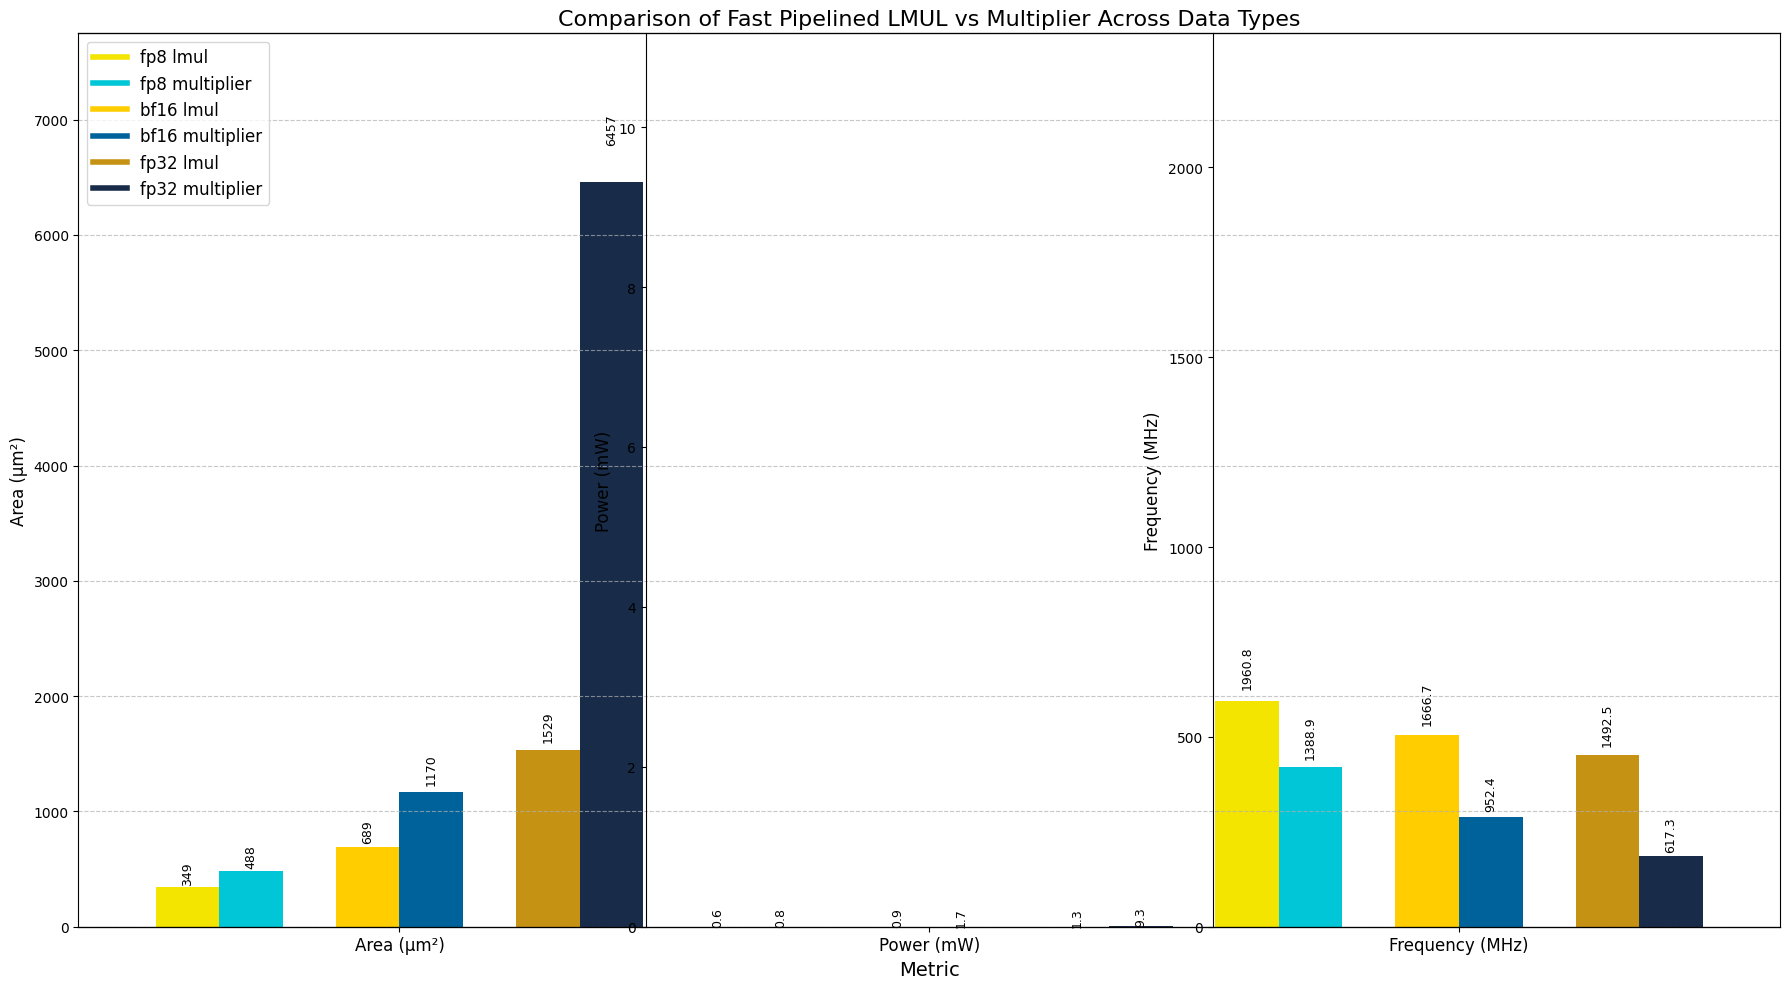

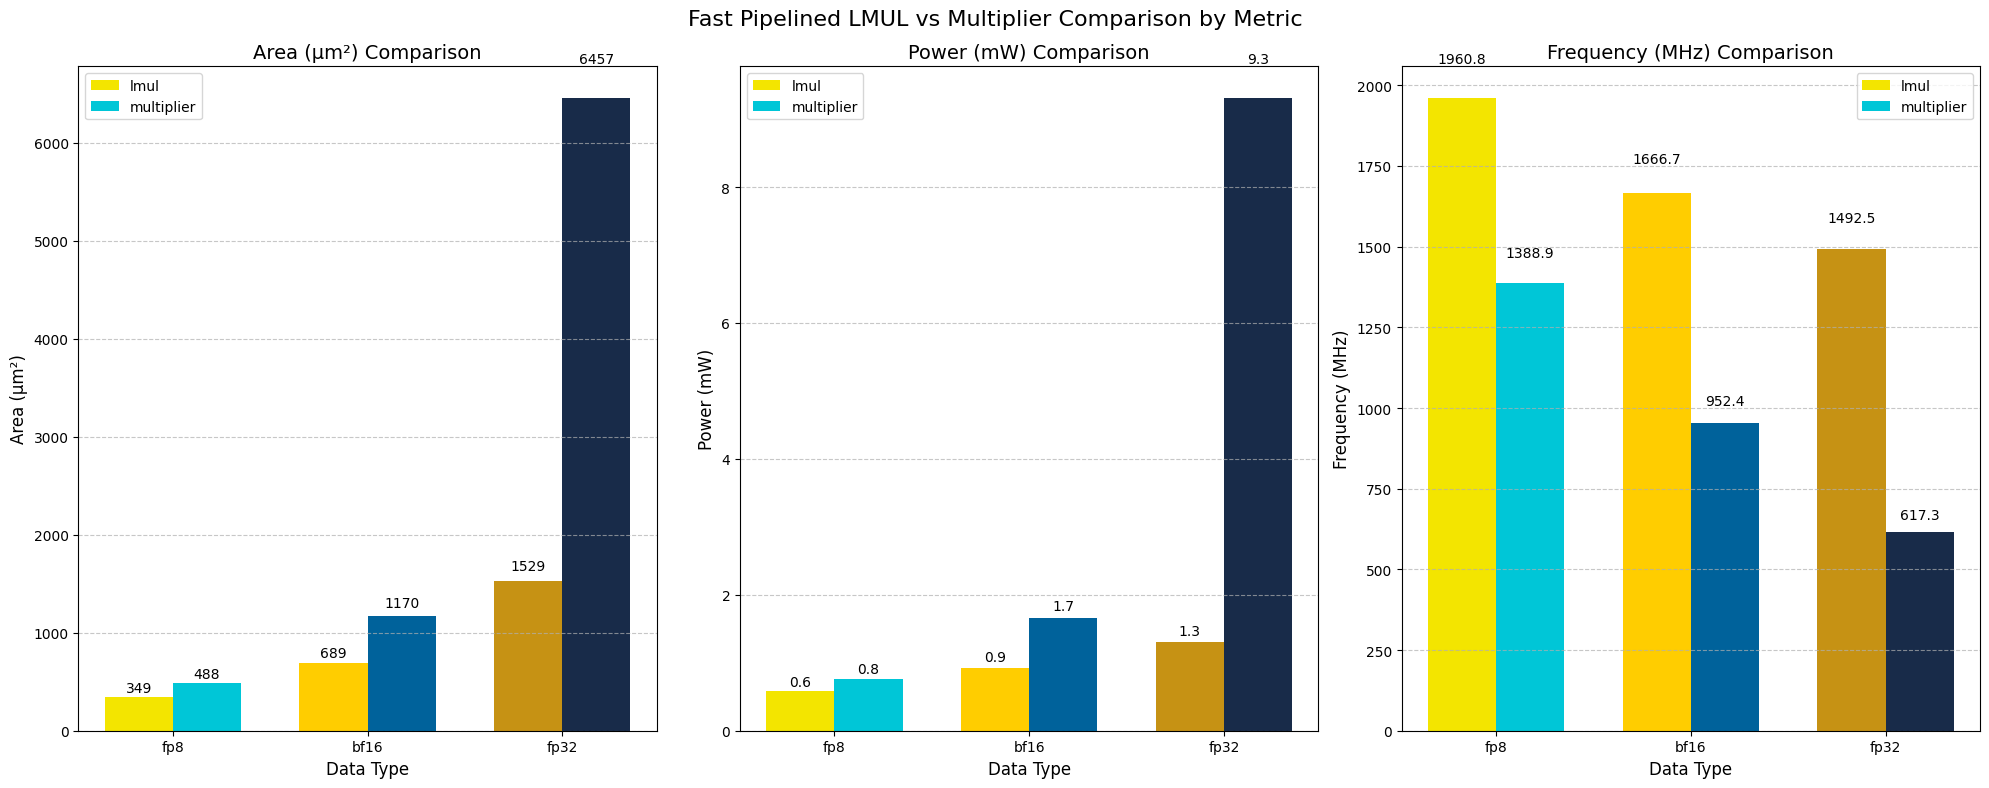

In [ ]:
# Filter for fast pipelined multiplier and lmul implementations
fast_pipelined_mask = (
    df["name"].str.contains("multiplier_pipelined") & df["name"].str.contains("fast")
) | (df["name"].str.contains("lmul_pipelined") & df["name"].str.contains("fast"))
fast_pipelined_df = df[fast_pipelined_mask].copy()

# Convert power from watts to milliwatts
fast_pipelined_df["power"] = fast_pipelined_df["power"] * 1000

# Calculate frequency in MHz (1/delay in ns * 1000)
fast_pipelined_df["frequency"] = 1000 / fast_pipelined_df["max_arrival_time"]

# Prepare data for grouped bar chart
# Melt the dataframe to have metrics as a variable
melted_df = pd.melt(
    fast_pipelined_df,
    id_vars=["name", "dtype_order", "operation"],
    value_vars=["area", "power", "frequency"],
    var_name="metric",
    value_name="value",
)

# Map metric names to more readable labels
metric_labels = {
    "area": "Area (μm²)",
    "power": "Power (mW)",
    "frequency": "Frequency (MHz)",
}
melted_df["metric"] = melted_df["metric"].map(metric_labels)

# Create the grouped bar chart
plt.figure(figsize=(18, 10))

# Define custom colors as specified
colors = {
    "fp8": {"lmul": "#F3E500", "multiplier": "#00C6D7"},
    "bf16": {"lmul": "#FFCD00", "multiplier": "#00629B"},
    "fp32": {"lmul": "#C69214", "multiplier": "#182B49"},
}

# Set the positions for the bars
metrics = list(metric_labels.values())
n_metrics = len(metrics)
n_dtypes = 3
bar_width = 0.12
group_spacing = 0.1
dtype_group_width = 2 * bar_width + group_spacing

# Calculate positions for each group
index = np.arange(n_metrics)
positions = {}

for i, metric in enumerate(metrics):
    for j, dtype in enumerate(["fp8", "bf16", "fp32"]):
        # Position for this dtype group
        dtype_pos = index[i] + (j - 1) * dtype_group_width
        positions[(metric, dtype, "lmul")] = dtype_pos - bar_width / 2
        positions[(metric, dtype, "multiplier")] = dtype_pos + bar_width / 2

# Plot bars for each dtype and operation
for dtype in ["fp8", "bf16", "fp32"]:
    for op in ["lmul", "multiplier"]:
        # Filter data for this dtype and operation
        data = melted_df[
            (melted_df["dtype_order"] == dtype) & (melted_df["operation"] == op)
        ]

        # Plot bars for each metric
        for metric in metrics:
            metric_data = data[data["metric"] == metric]
            if not metric_data.empty:
                val = metric_data["value"].mean()
                pos = positions[(metric, dtype, op)]

                bar = plt.bar(
                    pos,
                    val,
                    bar_width,
                    color=colors[dtype][op],
                    label=f"{dtype} {op}" if metric == metrics[0] else "",
                )

                # Add value labels on top of bars
                height = val
                if metric == "Area (μm²)":
                    label = f"{height:.0f}"
                elif metric == "Power (mW)":
                    label = f"{height:.1f}"
                else:  # Frequency
                    label = f"{height:.1f}"

                plt.text(
                    pos,
                    height + 0.05 * height,
                    label,
                    ha="center",
                    va="bottom",
                    fontsize=9,
                    rotation=90,
                )

# Customize the plot
plt.xlabel("Metric", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title(
    "Comparison of Fast Pipelined LMUL vs Multiplier Across Data Types", fontsize=16
)

# Set x-ticks at the center of each metric group
plt.xticks(index, metrics, fontsize=12)

# Add grid lines
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Create a custom legend
from matplotlib.lines import Line2D

legend_elements = []
for dtype in ["fp8", "bf16", "fp32"]:
    for op in ["lmul", "multiplier"]:
        legend_elements.append(
            Line2D([0], [0], color=colors[dtype][op], lw=4, label=f"{dtype} {op}")
        )
plt.legend(handles=legend_elements, loc="upper left", fontsize=12)

# Create separate y-axis scales for each metric
axes = [plt.gca()] + [plt.gca().twinx() for _ in range(n_metrics - 1)]
for i, ax in enumerate(axes):
    if i > 0:
        # Move the axis to the correct position
        ax.spines["left"].set_position(("axes", i / n_metrics))
        ax.spines["right"].set_visible(False)
        ax.yaxis.set_label_position("left")
        ax.yaxis.set_ticks_position("left")

    # Set the y-limits based on the data for this metric
    metric = metrics[i]
    metric_data = melted_df[melted_df["metric"] == metric]
    max_val = metric_data["value"].max() * 1.2  # Add 20% headroom
    ax.set_ylim(0, max_val)

    # Set the y-label
    ax.set_ylabel(metric, fontsize=12)

plt.tight_layout()
plt.savefig(
    os.path.join(SAVE_DIR, "fast_pipelined_absolute_comparison_updated.png"), dpi=300
)
plt.show()

# Create a version with separate subplots for better readability
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for this metric
    metric_data = melted_df[melted_df["metric"] == metric]

    # Set positions for bars
    n_groups = 3  # fp8, bf16, fp32
    index = np.arange(n_groups)
    bar_width = 0.35

    # Plot bars for lmul and multiplier
    for j, op in enumerate(["lmul", "multiplier"]):
        # Filter data for this operation
        op_data = metric_data[metric_data["operation"] == op]

        # Get values for each dtype
        values = []
        colors_list = []
        for dtype in ["fp8", "bf16", "fp32"]:
            val = op_data[op_data["dtype_order"] == dtype]["value"].mean()
            values.append(val)
            colors_list.append(colors[dtype][op])

        # Plot the bars
        pos = index + (j - 0.5) * bar_width
        bars = ax.bar(pos, values, bar_width, label=op, color=colors_list)

        # Add value labels
        for k, bar in enumerate(bars):
            height = bar.get_height()
            if metric == "Area (μm²)":
                label = f"{height:.0f}"
            elif metric == "Power (mW)":
                label = f"{height:.1f}"
            else:  # Frequency
                label = f"{height:.1f}"
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.05 * height,
                label,
                ha="center",
                va="bottom",
                fontsize=10,
            )

    # Customize subplot
    ax.set_xlabel("Data Type", fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f"{metric} Comparison", fontsize=14)
    ax.set_xticks(index)
    ax.set_xticklabels(["fp8", "bf16", "fp32"])
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend()

plt.suptitle("Fast Pipelined LMUL vs Multiplier Comparison by Metric", fontsize=16)
plt.tight_layout()
plt.savefig(
    os.path.join(SAVE_DIR, "fast_pipelined_absolute_comparison_by_metric_updated.png"),
    dpi=300,
)
plt.show()